In [1]:
%autosave 20

Autosaving every 20 seconds


# Introduction

This project explores predicting sonic logs (MDT) for a given oil well based on already logged data. The primary aim was to determine how accurately logs from a well in given block could predict the sonic log for another well either in the same block or in a different block. Based on the function of sonic logs in well logging, the following logs – Potassium (POTA), GammaRay(GR), NeutronPorosity(NPHI),   Resistivity (LLD), Density(RHOB), Uranium (URAN), Thromium(TH) were used to build 3 models – Linear Regression, Random Forrest and Deep Neural Network


## Methodology

The process builds models from oilwell log located in the Midland Basin - Block 5, Section 35.
First exploratory data analysis was carried out, the machine learning models where then built using cross validation. To test another oilwell log from Block 5, section 16 was used to test.
Next outliers where taken out, models where rebuilt again and tested, this both with outliers and without outliers in the test dataset.

# Data Preparation

Python has a well developed library LASIO for reading the well log (.las) files. The LASIO library was used to extract the logs into a pandas dataframe that could then be explored and utilized for model building. 
The same process is used for the test dataframe

In [2]:
pip install petrolib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import lasio as la
import numpy as np
import pandas as pd
import petrolib

from petrolib.plots import plotLog, plotLogs
from petrolib.procs import set_alias

### View the log description

In [3]:
las = la.read(r'C:\Users\yoges\OneDrive\Documents\Programming\Sonic Logs Prediction\4200341370.las')
print(las.curves)

Mnemonic  Unit  Value           Description       
--------  ----  -----           -----------       
DEPT      F     00 000 000 000  Depth             
GRTO      api   00 000 000 000  GammaTotal        
GRKT      api   00 000 000 000  GammaKT           
GRTH      api   00 000 000 000  GammaTh           
GKUT      api   00 000 000 000  GammaKUT          
POTA      %     00 000 000 000  Potassium         
URAN      ppm   00 000 000 000  Uranium           
THOR      ppm   00 000 000 000  Thorium           
MSFL      ohmm  00 000 000 000  MSFL              
LLS       ohmm  00 000 000 000  LLS               
LLD       ohmm  00 000 000 000  LLD               
GR        api   00 000 000 000  Gamma API         
CALI      in    00 000 000 000  Caliper           
BHVT      ft3   00 000 000 000  Borehole Volume   
AHVT      ft3   00 000 000 000  Annular Volume    
RHOB      g/cc  00 000 000 000  Density           
DRHO      g/cc  00 000 000 000  DensityCorr       
PE        b/e   00 000 000 000 

In [4]:
las.params

[HeaderItem(mnemonic="DCS", unit="", value="03-May-10", descr="DateCircEndT"),
 HeaderItem(mnemonic="TCS", unit="", value="12 09", descr="Time Ciculation Ende"),
 HeaderItem(mnemonic="DLAB", unit="", value="03-May-10", descr="LogStartDateT"),
 HeaderItem(mnemonic="TLAB:1", unit="", value="12 09", descr="LogStartTimeT"),
 HeaderItem(mnemonic="DATE", unit="", value="03-May-10", descr="Run Date"),
 HeaderItem(mnemonic="TDCE", unit="ucts", value="12.09.36 03-May-10", descr="Ti"),
 HeaderItem(mnemonic="TLAB:2", unit="ucts", value="12.09.36 03-May-10", descr="")]

In [5]:
train = pd.DataFrame(las.data, columns=list(las.curvesdict.keys()))


train.shape

(22021, 29)

In [6]:
train.columns

Index(['DEPT', 'GRTO', 'GRKT', 'GRTH', 'GKUT', 'POTA', 'URAN', 'THOR', 'MSFL',
       'LLS', 'LLD', 'GR', 'CALI', 'BHVT', 'AHVT', 'RHOB', 'DRHO', 'PE',
       'DPHI', 'XPHI', 'NPHI', 'NDSN', 'FDSN', 'TENS', 'MDT', 'SPHI', 'ITTT',
       'DXDT', 'DYDT'],
      dtype='object')

### Import the data frame

### Extract Second Well Log For Test

In [7]:
las2 = la.read(r'C:\Users\yoges\OneDrive\Documents\Programming\Sonic Logs Prediction\4200340497.las')
test = pd.DataFrame(las2.data, columns=list(las.curvesdict.keys()))
test.dropna(axis=0,how='any',inplace=True)
test.reset_index()
test.shape

(13428, 29)

In [9]:
print(test.tail())
print(test.shape)

          DEPT     GRTO     GRKT     GRTH    GKUT    POTA    URAN     THOR  \
22380  11379.5  22.0016  10.9165  25.9080  1.0715  2.4495  3.0978  45.2246   
22381  11380.0  20.7571  10.3862  21.8873  0.8220  2.3110  2.9473  54.2522   
22382  11380.5  19.0655   7.7526  14.6304  0.4916  2.1226  2.1999  49.6060   
22383  11381.0  15.7442   6.3101  11.0358  0.3378  1.7529  1.7906  37.6400   
22384  11381.5  16.6113   6.4050  11.0599  0.3327  1.8494  1.8175  28.6391   

          MSFL     LLS  ...    XPHI    NPHI    NDSN       FDSN     TENS  \
22380  50.0704  0.0489  ... -0.0600  0.3260  0.0436  3241.3027  59.4304   
22381  60.3566  0.0247  ... -0.2609  0.0378  0.0142  3249.6738  58.5057   
22382  55.6182  0.0186  ... -0.0602  0.0667  0.0106  3258.3689  56.9236   
22383  43.2923  0.0194  ...  0.1844  0.0459  0.0204  3306.4316  56.2840   
22384  32.0329  0.0291  ...  0.1551  0.1434  0.0342  3299.5266  57.0429   

            MDT      SPHI    ITTT       DXDT    DYDT  
22380  104.9058  105.0462

In [9]:
def trim_log_values(df, depth_column, log_list):

    """
    Pick the start and end values of multiple logs based on the given conditions.

    Parameters:
    df (DataFrame): The pandas DataFrame containing the log data.
    column1 (str): The column from which to retrieve the values, 'DEPTH in this case'.
    log_list (list): A list of log names to determine the start and end of the logs.

    Returns:
    DataFrame: A pandas DataFrame containing the start and end values of each log.
    """
    trim_data = []
    
    for log in log_list:
        mask = df[log].notnull()  # Create a boolean mask where non-missing values in log are True
        start_index = mask.idxmax()  # Find the index of the first True value
        last_index = mask[::-1].idxmax()  # Find the index of the last True value by reversing the mask
        start_value = df.loc[start_index, depth_column]  # Retrieve the corresponding start value from column1(depth)
        end_value = df.loc[last_index, depth_column]  # Retrieve the corresponding end value from column1(depth)
        trim_data.append([log, start_value, end_value])
    
    trim_df = pd.DataFrame(trim_data, columns=['Log', 'Start Value', 'End Value'])
    return trim_df

In [10]:
print(trim_log_values(train,'DEPT', ['GR', 'LLD', 'NPHI',  'RHOB','MDT']))

    Log  Start Value  End Value
0    GR        200.0    11089.5
1   LLD       4450.5    11191.5
2  NPHI        200.0    11115.0
3  RHOB       4458.0    11126.0
4   MDT       4461.0    11157.0


In [11]:
print(train.isna().sum())

DEPT       0
GRTO    8759
GRKT    8759
GRTH    8759
GKUT    8759
POTA    8759
URAN    8759
THOR    8759
MSFL    6508
LLS     8538
LLD     8538
GR       241
CALI    8669
BHVT    8669
AHVT    8669
RHOB    8684
DRHO    8684
PE      8684
DPHI    8684
XPHI    8706
NPHI     190
NDSN     190
FDSN     190
TENS       0
MDT     8671
SPHI    8671
ITTT    8769
DXDT    8811
DYDT    8813
dtype: int64


In [12]:
train.dropna(axis=0,how='any',inplace=True)
train.shape

(13020, 29)

## Exploratory Data Analysis

Based on petroleum engineering log literature the following logs will be dropped:\
CALI & TENS are tool calibration (this will be dropped after confirmation that there is no washout) and tension logs\
DRHO, XPHI, SPHI, DPHI, NDSN, FDSN, ITTT are calculated from the recorded logs\
MSFL and LLS are resistivity logs but LLD will be used since it records resisitivity in an uninvaded formation \
AHVT measures the volume of the well where cement is to be poured\
GRTO, GRTH , GRKT, and GKUT are various gamma rays because GKUT and GRTO measure the same thing and GKUT is not available in a lot of logs\

The variable to be predicted is MDT - mono delta t\
Some of the variables like the resistivity logs have a very spread out distribution, for example LLD is heavily right skewed\

### Checking Data For Washout

Washout occurs when the rock formation is much wider than the hole originaly bored by the tool. An effect of washout is that the caliper tool reads data from mud or water. One way to confirm there is washout is to confirm that the caliper readings are not more than 1.5 times larger than what was set.
From the summary below, it was determined that there was washout because the caliper had a maximum reading of 22.411600\

In [13]:
# CALI - caliper log will be used to determine washout then dropped
train.drop(columns = ['TENS','DRHO','XPHI','SPHI','DPHI','NDSN','FDSN','ITTT','MSFL','LLS','AHVT','GRTO','GRTH','GRKT','GKUT','DXDT','DYDT'], inplace=True)
train.describe()

,DEPT,POTA,URAN,THOR,LLD,GR,CALI,BHVT,RHOB,PE,NPHI,MDT
count,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000
mean,7821.117281,1.406437,3.387219,4.632478,864.000566,66.415054,8.449059,1262.640400,2.573042,3.431235,0.144308,67.293916
std,1884.012138,0.765648,2.087910,2.851356,4044.583167,34.561351,0.499220,730.571224,0.130893,0.805665,0.072319,10.904100
min,4475.000000,0.040500,0.129900,0.113000,0.044500,2.713600,6.647000,41.589200,1.002800,1.208900,-0.012600,41.114400
25%,6191.375000,0.672200,1.758550,2.002425,19.972025,37.579275,8.160600,629.894575,2.494000,2.850375,0.083300,58.393925
50%,7818.750000,1.571650,2.921950,4.539300,66.606950,62.908400,8.269100,1233.866100,2.563500,3.258250,0.154800,69.568250
75%,9449.125000,1.983675,4.789150,6.890750,205.622875,93.816950,8.644925,1891.929100,2.641225,3.956850,0.192100,74.593125
max,11089.500000,4.021900,22.411600,14.421400,40000.000000,258.443600,22.016100,2747.968300,2.997100,9.677000,0.856700,181.575800


## Exploratory Analysis

The train dataset will be utilized for analysis afterwhich it will be dropped.

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

###  Variable Distribution - Histograms

#### Histograms For The Whole Data

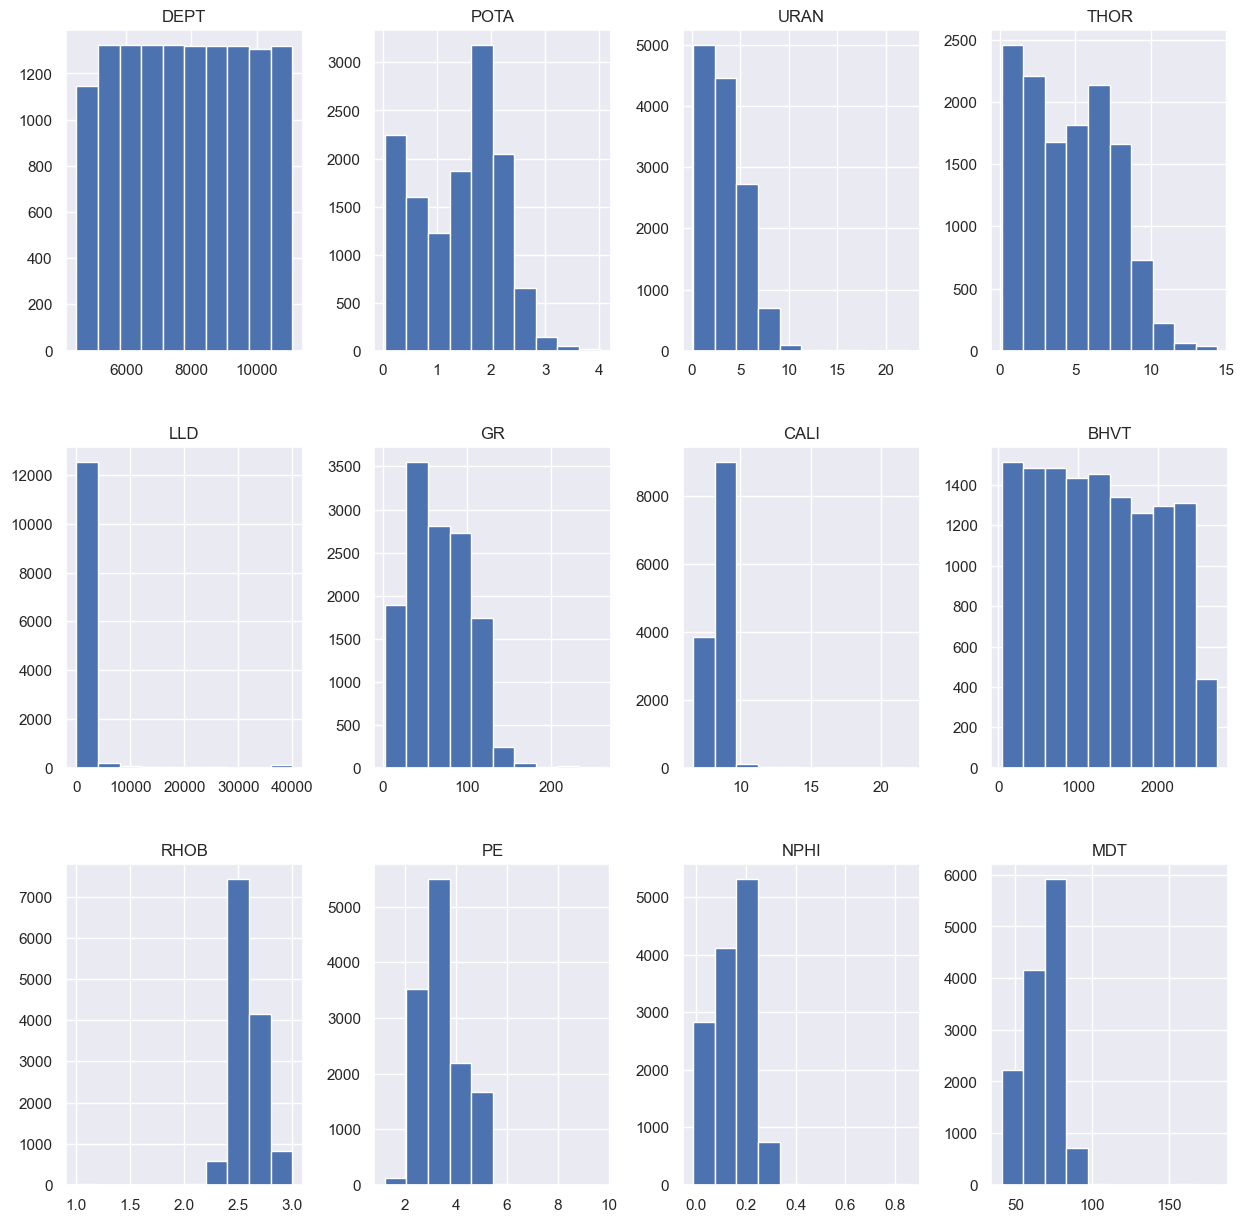

In [15]:
train.hist(bins=10,figsize=(15, 15), layout=(3, 4))
plt.show()

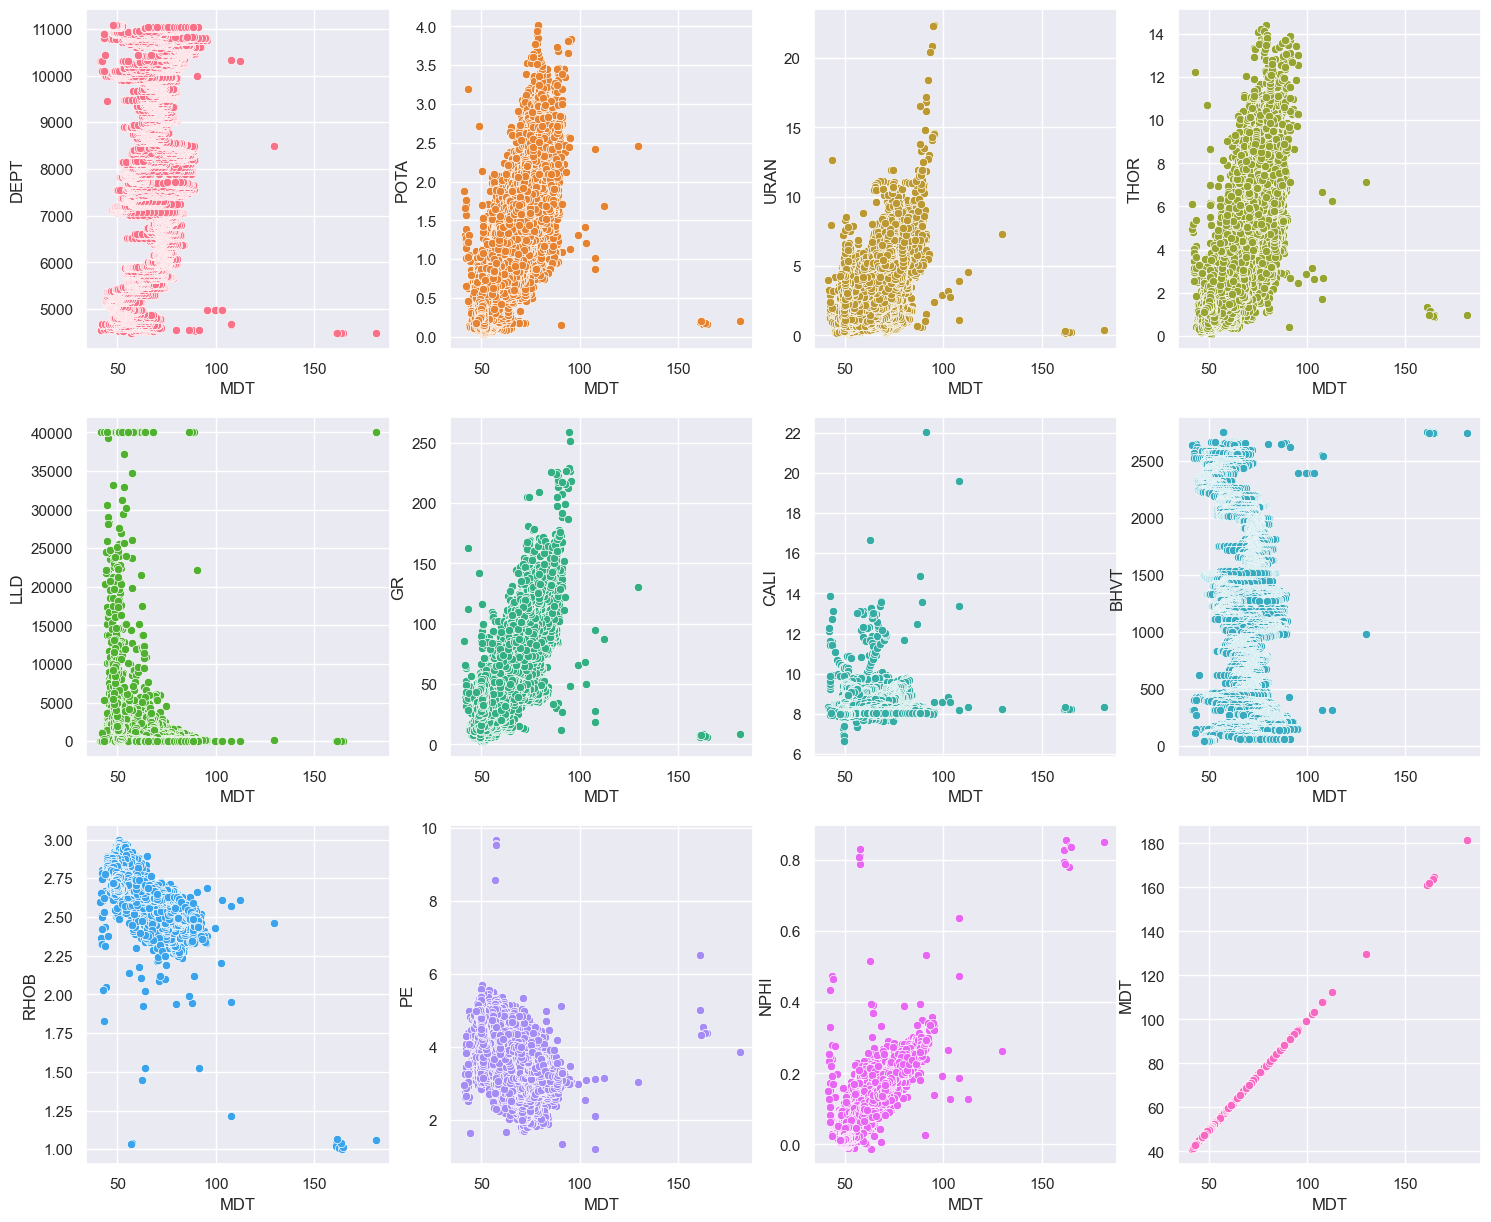

In [16]:
names = train.columns
fig, ax = plt.subplots(3, 4, figsize=(18, 15))
palette = sns.color_palette("husl", len(names))  # You can choose any palette

for variable, subplot, color in zip(names, ax.flatten(), palette):
    sns.scatterplot(x=train['MDT'], y=train[variable], ax=subplot, color=color)
    

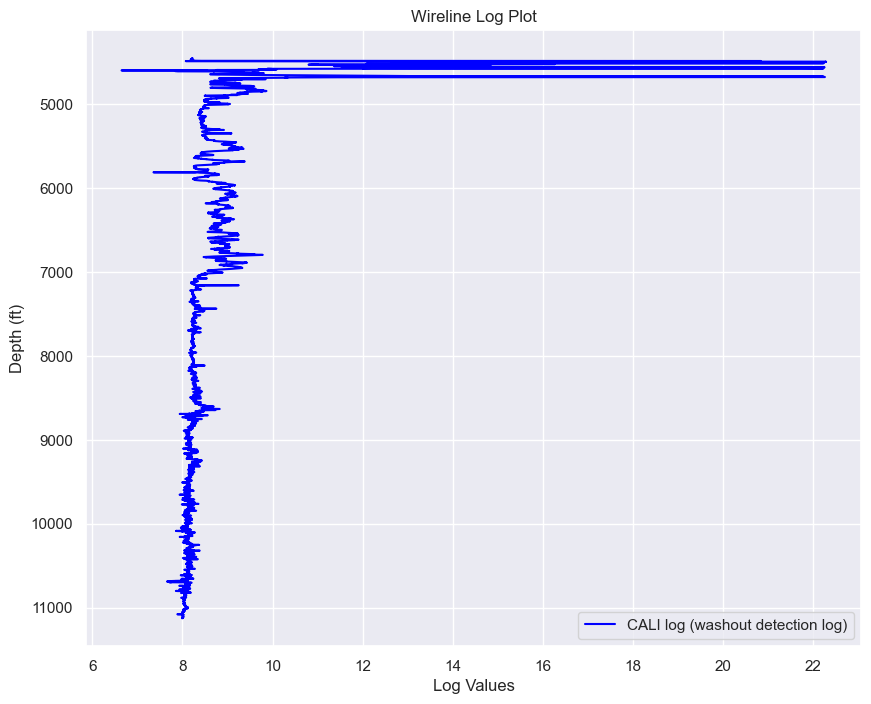

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the curves
ax.plot(las['CALI'], las['DEPT'], color='blue', label='CALI log (washout detection log)')


# Invert the y-axis to represent depth correctly
ax.invert_yaxis()

# Add labels and title
ax.set_xlabel('Log Values')
ax.set_ylabel('Depth (ft)')
ax.set_title('Wireline Log Plot')

# Add a legend
ax.legend()

# Show the plot
plt.show()

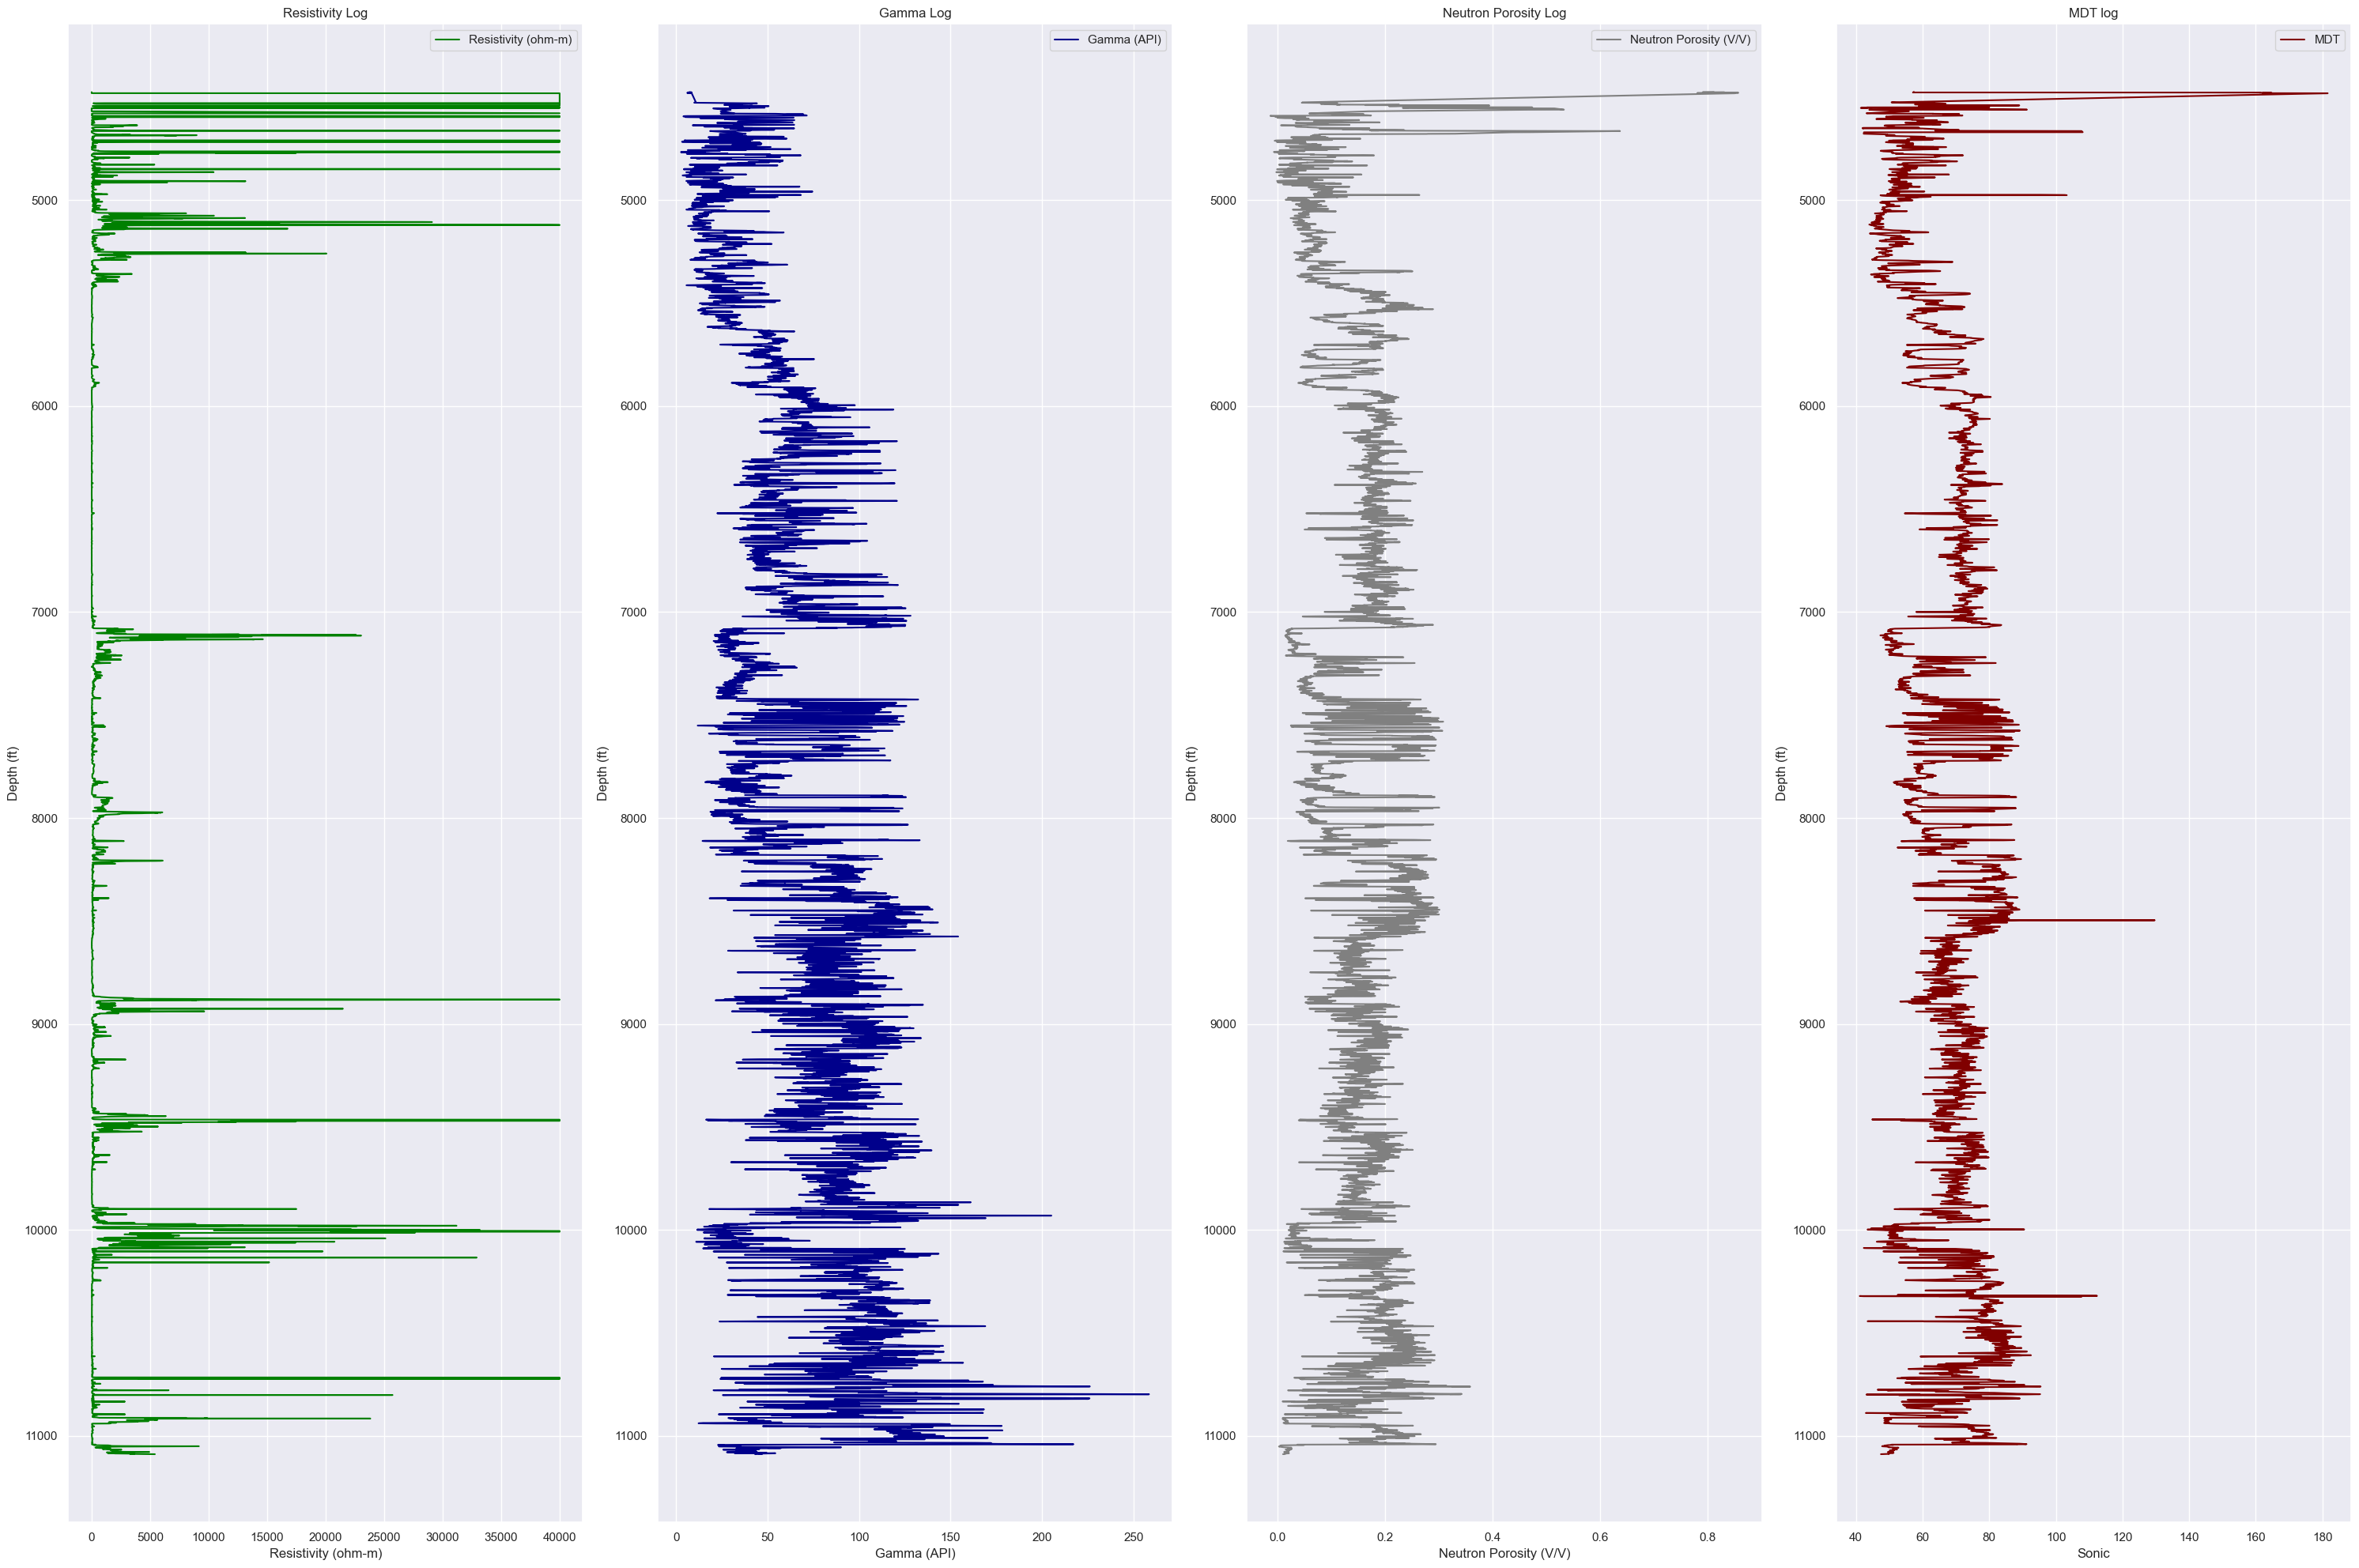

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(30, 20))

# Plot Resistivity
ax[0].plot(train['LLD'],train['DEPT'], color='green', label='Resistivity (ohm-m)')
ax[0].invert_yaxis()  # Invert the y-axis for depth
ax[0].set_xlabel('Resistivity (ohm-m)')
ax[0].set_ylabel('Depth (ft)')
ax[0].set_title('Resistivity Log')
ax[0].legend()

# Plot Gamma
ax[1].plot(train['GR'],train['DEPT'], color='darkblue', label='Gamma (API)')
ax[1].invert_yaxis()  # Invert the y-axis for depth
ax[1].set_xlabel('Gamma (API)')
ax[1].set_ylabel('Depth (ft)')
ax[1].set_title('Gamma Log')
ax[1].legend()

# Plot Sonic log
ax[3].plot(train['MDT'],train['DEPT'], color='maroon', label='MDT')

ax[3].invert_yaxis()  # Invert the y-axis for depth
ax[3].set_xlabel('Sonic')
ax[3].set_ylabel('Depth (ft)')
ax[3].set_title('MDT log')
ax[3].legend()

# Plot Neutron Porosity
ax[2].plot(train['NPHI'],train['DEPT'], color='gray', label='Neutron Porosity (V/V)')
ax[2].invert_yaxis()  # Invert the y-axis for depth
ax[2].set_xlabel('Neutron Porosity (V/V)')
ax[2].set_ylabel('Depth (ft)')
ax[2].set_title('Neutron Porosity Log')
ax[2].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

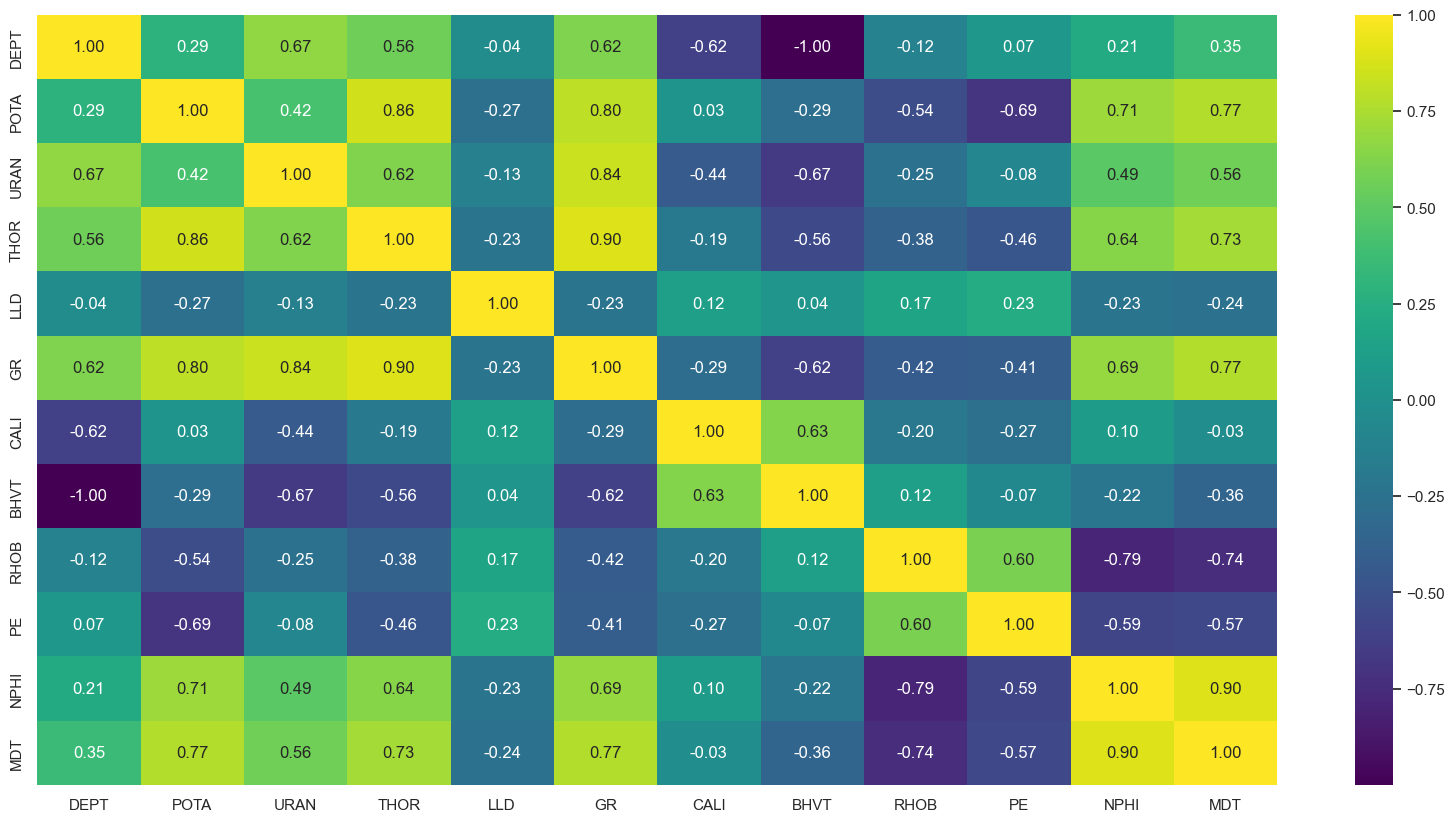

In [19]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(train.corr(),annot=True, fmt='0.2f',cmap = 'viridis', ax=ax);

Determining the relationship between the predictors and the Sonic log variable
Well Depth and Volume dont appear to have linear relationship with the Sonic Log and because they are highly collinear Volume will be dropped because logic would dictate that values might change as depth increases.
The univariate distribution of resistivity is heavily skewed, and so its relationship with Sonic Log is unclear. The relationship appears to be non-linear.
The rest have a clear linear relationship: Postassim, Uranium, Thromuim, Gamma Ray and Neutron Porosity have a positive relationship and Density and Photo Electric logs have a negative linear relationship with Sonic Log

Resistivity, uranium and gamma ray have skewed data and need to be transformed. First skewness will be tested, and all skewed features will be transformed utilizing Box-Cox transformation
To ensure that no feature is more influential than another due to its values, min-max scaling will be utilized if necessary on features that where not previously Power transformed.

### Skewness Test & Data Transformation

The test for skewness on the complete data showed that Resitivity , Neutron Porosity, Uranium, Photoelectric, GammaRay,Thromium and RHOB all have skewness.\
As such they need to be transformed for normality, NPHI has negative values and so a Yeo-Johnson transformation is performed, Box-Cox is utilized for the rest.\
Also Depth has values that are extremely larger than all the other values and so Min-Max scaler is used to constrain the values to a range between 0 and 1.\
Potassium is not transformed because it does not have noticable skew and the values are not excessively large.\


In [20]:
from scipy.stats import skew
train.drop(columns = 'BHVT', inplace=True)
train.apply(lambda x: skew(x)).sort_values(ascending=False)

LLD     8.032503
CALI    5.767533
URAN    1.103542
NPHI    0.704537
PE      0.630133
GR      0.415345
THOR    0.315809
MDT     0.269944
DEPT    0.002116
POTA   -0.076621
RHOB   -1.301133
dtype: float64

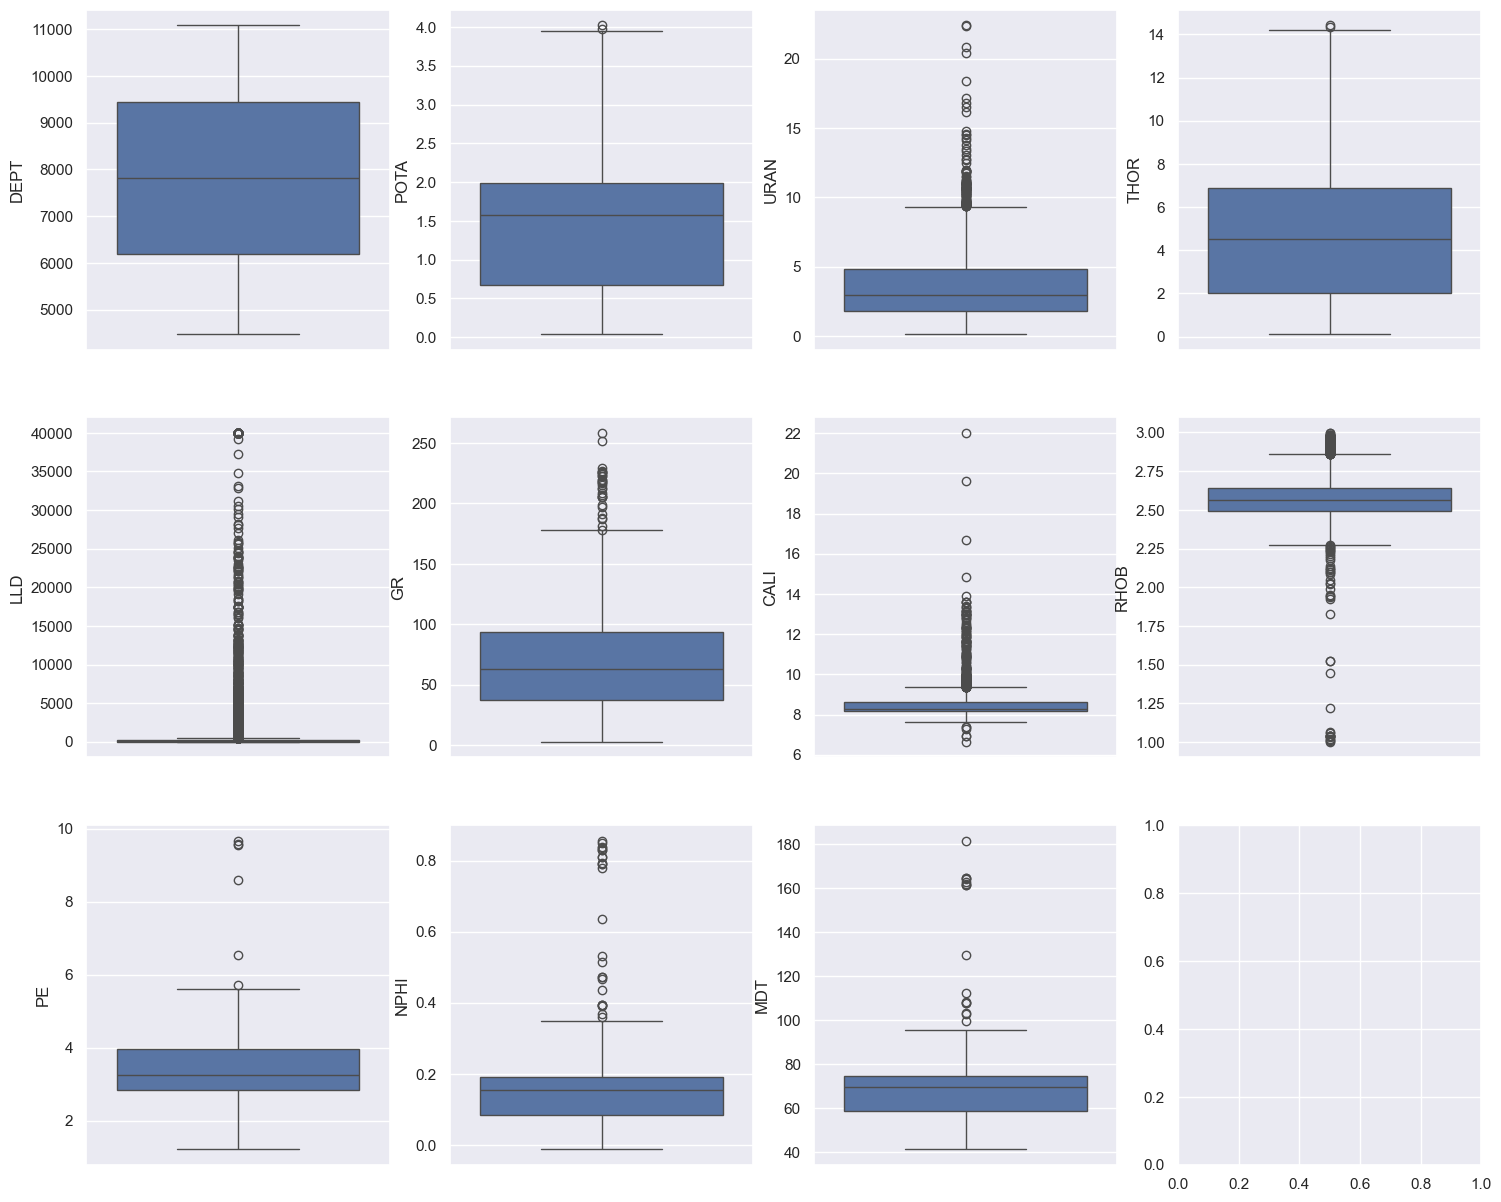

In [21]:
names = train.columns
fig, ax = plt.subplots(3,4, figsize=(18, 15))
for variable, subplot in zip(names, ax.flatten()):
    b = sns.boxplot(train[variable], orient = "v", ax=subplot)

## Data Modelling

Since outliers are suspected, observations were dropped using the difference between the observed caliper measurement in the logs and 7.88 which was the set measure for the caliper. '

Three data sets with the following labels listed below will be created

 * x_all & y_all - original dataset
 * x_small & y_small - dataset with only caliper outliers dropped
 * x_no_out & y_no_out - dataset outliers from all logs dropped

Next the data is then split into the y variable MDT and the independent variables which is all the other variables.

In [22]:
def iqr_range(df):
    det = df.describe()
    iqr_dict = dict()
    for col in det.columns:
        Q1 = det.loc['25%',col]
        Q3 = det.loc['75%',col]
        iqr = Q3 - Q1
        low = Q1 - (1.5 * iqr)
        up = Q3 + (1.5 * iqr)
        iqr_dict.update({col:[low,up]})
    return iqr_dict

iqr_dict = iqr_range(train)
   
iqr_dict


{'DEPT': [np.float64(1304.75), np.float64(14335.75)],
 'POTA': [np.float64(-1.2950125000000003), np.float64(3.9508875000000003)],
 'URAN': [np.float64(-2.7873500000000004), np.float64(9.33505)],
 'THOR': [np.float64(-5.3300625), np.float64(14.2232375)],
 'LLD': [np.float64(-258.50425), np.float64(484.09915)],
 'GR': [np.float64(-46.7772375), np.float64(178.17346249999997)],
 'CALI': [np.float64(7.4341125), np.float64(9.371412500000002)],
 'RHOB': [np.float64(2.2731625000000006), np.float64(2.8620624999999995)],
 'PE': [np.float64(1.1906625), np.float64(5.616562500000001)],
 'NPHI': [np.float64(-0.07989999999999998), np.float64(0.35529999999999995)],
 'MDT': [np.float64(34.09512499999999), np.float64(98.89192500000001)]}

In [23]:
#Get 25th and 75th Percentiles
    
#Function to drop outliers
def drop_outliers(df,iqr_dict,col):
    if col == 0:
        df = df[(df['CALI'] >= iqr_dict['CALI'][0]) & (df['CALI'] <= iqr_dict['CALI'][1])]
        return df
    else:
        for key in iqr_dict:
            df = df[(df[key] >= iqr_dict[key][0]) & (df[key] <= iqr_dict[key][1])]
        return df

df_small = drop_outliers(train,iqr_dict,0)
df_no_out = drop_outliers(train,iqr_dict,1)

print("Shape of dataframe with caliper outliers removed:", df_small.shape)
print("Shape of dataframe with all log outliers removed:", df_no_out.shape)

Shape of dataframe with caliper outliers removed: (12673, 11)
Shape of dataframe with all log outliers removed: (10360, 11)


In [24]:
#Function To Drop Outliers and Split the Data
def split_df(df):    
    #Split the data
    x_split = pd.DataFrame(df[['URAN', 'THOR', 'LLD', 'GR', 'RHOB', 'PE','NPHI','DEPT']])
    y_split = df.loc[:,'MDT']
    return x_split,y_split


x_all, y_all = split_df(train)
x_small, y_small = split_df(df_small)
x_no_out, y_no_out = split_df(df_no_out)


Boxplots to veiw the effect of dropping observations

In [25]:
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler

#Box-Cox Transformation of Skewed Variables with Only Positive Values 
col_trans = make_column_transformer(
                                    (PowerTransformer(),['URAN', 'THOR', 'LLD', 'GR', 'RHOB', 'PE']),
                                    (PowerTransformer(method='yeo-johnson'),['NPHI']),
                                    (MinMaxScaler(),['DEPT'])
                                    )
x_all = col_trans.fit_transform(x_all)
x_small = col_trans.fit_transform(x_small)
x_no_out = col_trans.fit_transform(x_no_out)


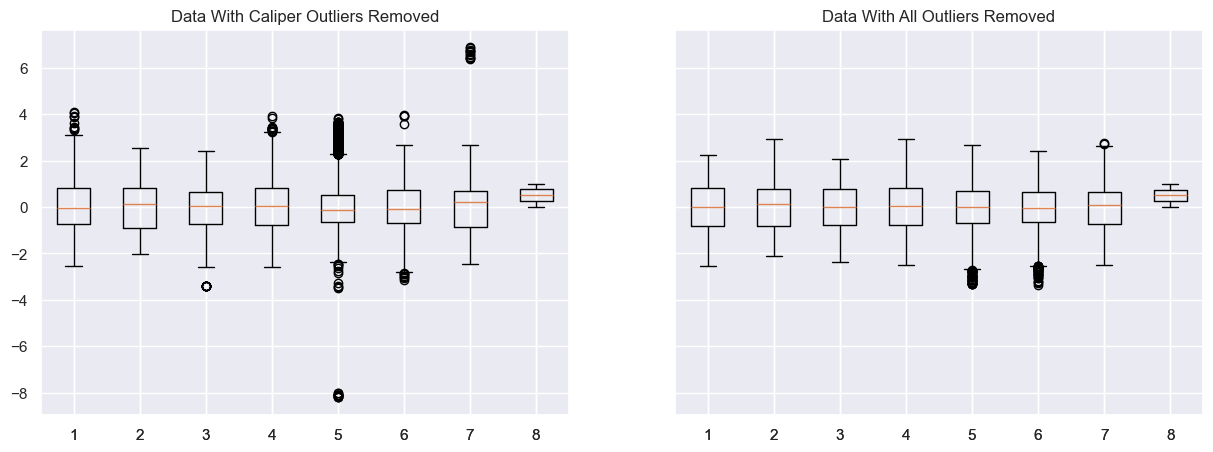

In [26]:
fig, (ax1,ax2) = plt.subplots(1,2, sharex=True,sharey=True,figsize=(15, 5))
ax1.set_title("Data With Caliper Outliers Removed",loc='center')
ax1.boxplot(x_small);

ax2.set_title("Data With All Outliers Removed",loc='center')
ax2.boxplot(x_no_out);

### Modelling

As seen above, the variables still have outliers as such the models utilized need to be robust to outliers
The following models will be utilzed and compared using their mean absolute error:
    * Linear Regression
    * Random Forest
    * Neural Network

In [27]:
def model_evaluation(model_cv1, model_cv2, model_cv3):
    result = pd.DataFrame({'Train MAE' : [model_cv1['train_neg_mean_absolute_error'].mean(), model_cv2['train_neg_mean_absolute_error'].mean(), model_cv3['train_neg_mean_absolute_error'].mean()],
                           'Validation MAE' : [model_cv1['test_neg_mean_absolute_error'].mean(), model_cv2['test_neg_mean_absolute_error'].mean(), model_cv3['test_neg_mean_absolute_error'].mean()],
                           'Train MSE' : [model_cv1['train_neg_mean_squared_error'].mean(), model_cv2['train_neg_mean_squared_error'].mean(), model_cv3['train_neg_mean_squared_error'].mean()],
                           'Test MSE' : [model_cv1['test_neg_mean_squared_error'].mean(), model_cv2['test_neg_mean_squared_error'].mean(), model_cv3['test_neg_mean_squared_error'].mean()],
                           'R2' : [model_cv1['train_r2'].mean(), model_cv2['train_r2'].mean(), model_cv3['train_r2'].mean()]},
                           index=['all data', 'no_caliper_outlier', 'no_outliers'])
    return result

# Linear Regression

This is the first choice of a baseline model to determine the relationship between the features and the sonic log. All the predictors have a significant relationship with the model.

Since all the datasets have outliers, the cross validation result is compared betweeb datasets using the mean absolute error.

In [59]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error,mean_squared_error,root_mean_squared_error
from sklearn.pipeline import Pipeline

lin_reg1 = LinearRegression()
lin_reg2 = clone(lin_reg1)
lin_reg3 = clone(lin_reg1)

lin_reg1.fit(x_all, y_all) 
lin_reg2.fit(x_small, y_small)
lin_reg3.fit(x_no_out, y_no_out)

lin_pred1 = lin_reg1.predict(x_all)
lin_pred2= lin_reg2.predict(x_small)
lin_pred3 = lin_reg3.predict(x_no_out)

lin_reg_cv1 = cross_validate(lin_reg1, x_all, y_all, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =10)
lin_reg_cv2 = cross_validate(lin_reg2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =10)
lin_reg_cv3 = cross_validate(lin_reg3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =10)


In [60]:
model_evaluation(lin_reg_cv1,lin_reg_cv2,lin_reg_cv3)

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-2.423524,-2.995963,-15.368562,-22.598058,0.871046
no_caliper_outlier,-2.274948,-2.817242,-12.959553,-19.727927,0.890633
no_outliers,-2.018077,-2.255785,-7.881652,-9.989538,0.906018


A comparison of error from this dataset would indicate that the x_no_out dataset (which is the dataset with outliers that have caliper difference +-1 ) is the better choice. Dropping the outliers has a positive impact on the results of the three datasets.
Training will still be done with all and then a final choice will be made.

# Elastic Net Regression

In [30]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score

elastic_model_1 = ElasticNet(alpha =0, l1_ratio= 0 , random_state=25 )
elastic_model_2 = clone(elastic_model_1)
elastic_model_3 = clone(elastic_model_1)

elastic_model_1.fit(x_all, y_all)
elastic_model_2.fit(x_small, y_small)
elastic_model_3.fit(x_no_out, y_no_out)

ElasticNet(alpha=0, l1_ratio=0, random_state=25)

In [31]:
elastic_pred_1 = elastic_model_1.predict(x_all)
elastic_pred_2 = elastic_model_2.predict(x_small)
elastic_pred_3 = elastic_model_3.predict(x_no_out)

In [32]:
el_cv1 = cross_validate(elastic_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
el_cv2 = cross_validate(elastic_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
el_cv3 = cross_validate(elastic_model_3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)

In [33]:
result_elastic_net = model_evaluation(el_cv1, el_cv2, el_cv3)
result_elastic_net

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-2.396692,-3.069166,-15.101984,-22.078619,0.873107
no_caliper_outlier,-2.250265,-2.819895,-12.753933,-18.110425,0.891950
no_outliers,-1.990051,-2.508445,-7.663875,-11.836573,0.906201


# Support Vector Regressor

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Scaling the data



svr_model_1 = SVR(kernel='rbf', C=1000, epsilon=0.5)
svr_model_2 = clone(svr_model_1)
svr_model_3 = clone(svr_model_1)

svr_model_1.fit(x_all, y_all)
svr_model_2.fit(x_small, y_small)
svr_model_3.fit(x_no_out, y_no_out)

SVR(C=1000, epsilon=0.5)

In [35]:
svr_pred_1 = svr_model_1.predict(x_all)
svr_pred_2 = svr_model_2.predict(x_small)
svr_pred_3 = svr_model_3.predict(x_no_out)



In [36]:
svr_cv1 = cross_validate(svr_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
svr_cv2 = cross_validate(svr_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
svr_cv3 = cross_validate(svr_model_3, x_no_out, y_no_out, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)

In [37]:
result_svr = model_evaluation(svr_cv1, svr_cv2, svr_cv3)
result_svr

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-1.212718,-3.748434,-4.417772,-36.210440,0.961776
no_caliper_outlier,-1.189206,-3.689742,-4.149790,-33.765396,0.963961
no_outliers,-1.116580,-2.968124,-3.084470,-16.978947,0.961903


# Random Forest Regressor

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


rf_model_1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_2 = clone(rf_model_1)
rf_model_3 = clone(rf_model_1)

rf_model_1.fit(x_all, y_all)
rf_model_2.fit(x_small, y_small)
rf_model_3.fit(x_no_out, y_no_out)

y_train_pred1 = rf_model_1.predict(x_all)
y_train_pred2 = rf_model_2.predict(x_small)
y_train_pred3 = rf_model_3.predict(x_no_out)

rf_cv1 = cross_validate(rf_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
rf_cv2 = cross_validate(rf_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
rf_cv3 = cross_validate(rf_model_3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)

In [39]:
result_rf = model_evaluation(rf_cv1,rf_cv2,rf_cv3)
result_rf

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-0.459863,-3.166065,-1.031816,-25.479194,0.991270
no_caliper_outlier,-0.442561,-3.189460,-0.880014,-24.364058,0.992511
no_outliers,-0.422081,-3.004438,-0.498522,-17.987994,0.993840


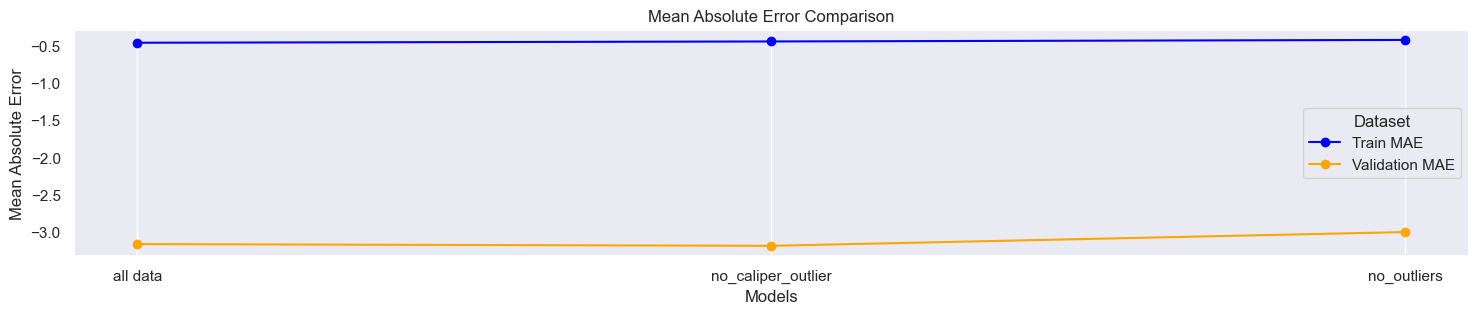

In [40]:
# Visualization: Line Plot for MAE, R², and MSE
plt.figure(figsize=(18, 10))

# MAE Plot
plt.subplot(3, 1, 1)
plt.plot(result_rf.index, result_rf['Train MAE'], marker='o', label='Train MAE', color='blue')
plt.plot(result_rf.index, result_rf['Validation MAE'], marker='o', label='Validation MAE', color='orange')
plt.title('Mean Absolute Error Comparison')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Models')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.grid(axis='y')



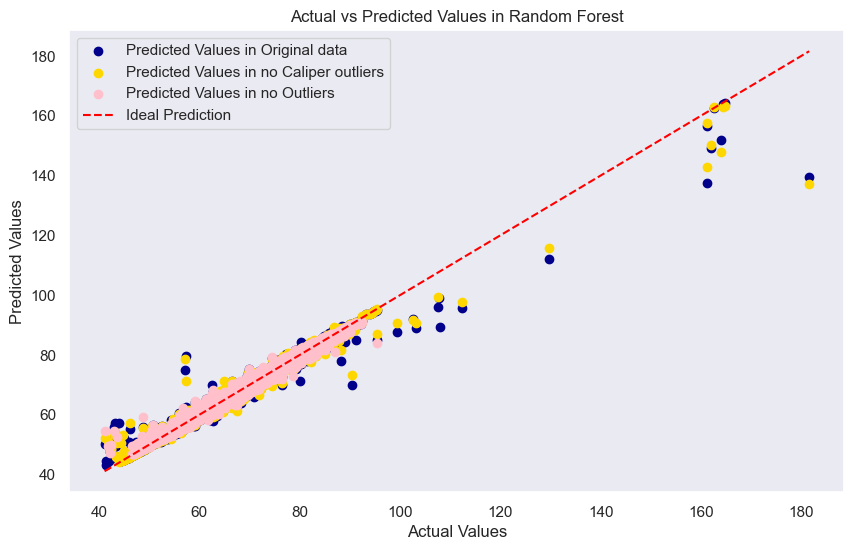

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(y_all, y_train_pred1, color='darkblue', label='Predicted Values in Original data')
plt.scatter(y_small, y_train_pred2, color='gold', label='Predicted Values in no Caliper outliers')
plt.scatter(y_no_out, y_train_pred3, color='pink', label='Predicted Values in no Outliers')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Values in Random Forest')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# KNN Model

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


knn_model_1 = KNeighborsRegressor(n_neighbors=5)  
knn_model_2 = clone(knn_model_1)
knn_model_3 = clone(knn_model_1)

knn_model_1.fit(x_all,y_all)
knn_model_2.fit(x_small,y_small)
knn_model_3.fit(x_no_out,y_no_out)

knn_y_pred1 = knn_model_1.predict(x_all)
knn_y_pred2 = knn_model_2.predict(x_small)
knn_y_pred3 = knn_model_3.predict(x_no_out)

knn_cv1 = cross_validate(knn_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
knn_cv2 = cross_validate(knn_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
knn_cv3 = cross_validate(knn_model_3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)


In [43]:
result_knn = model_evaluation(knn_cv1,knn_cv2,knn_cv3)
result_knn

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-0.983804,-3.179779,-4.785101,-22.963670,0.959389
no_caliper_outlier,-0.932407,-3.123337,-3.442110,-21.290422,0.970312
no_outliers,-0.929943,-2.881517,-2.520827,-14.498091,0.968785


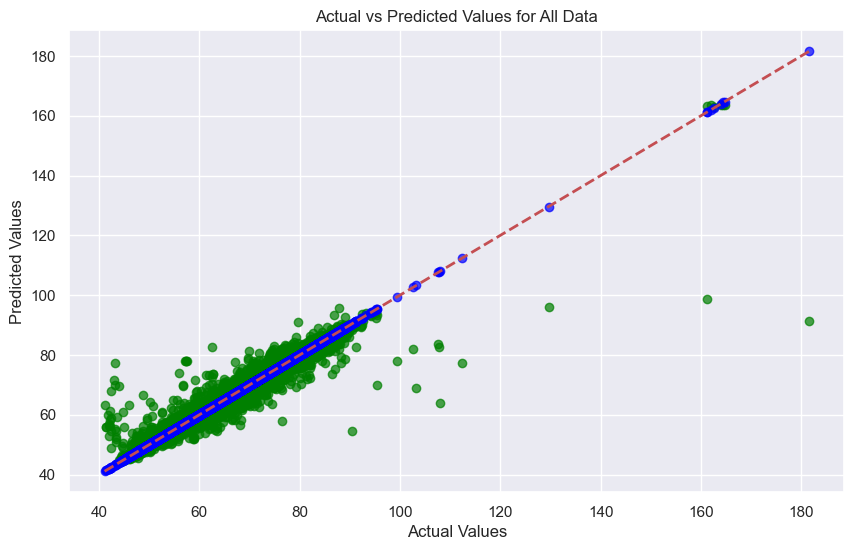

In [44]:
y_pred_all = knn_model_1.predict(x_all)  # Replace with your actual prediction
y_pred_small = knn_model_2.predict(x_small)  # Replace with your actual prediction
y_pred_no_out = knn_model_3.predict(x_no_out)  # Replace with your actual prediction

# Scatter plot for All Data

plt.figure(figsize=(10, 6))
plt.scatter(y_all, y_pred_all, alpha=0.7, color='green', label='Predicted Values')  # Change color for predicted values
plt.scatter(y_all, y_all, alpha=0.7, color='blue', label='Actual Values')  # Change color for actual
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], 'r--', lw=2)
plt.xlabel('Actual Values')  # X-axis label
plt.ylabel('Predicted Values')  # Y-axis label
plt.title('Actual vs Predicted Values for All Data')  # Title of the plot
plt.show()

# Partial Least Square Model

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler


n_components = 8  # You can adjust the number of components based on your analysis
pls_model_1 = PLSRegression(n_components=n_components)
pls_model_2 = clone(pls_model_1)
pls_model_3 = clone(pls_model_1)


pls_model_1.fit(x_all, y_all)
pls_model_2.fit(x_small, y_small)
pls_model_3.fit(x_no_out, y_no_out)

pls_pred_1 = pls_model_1.predict(x_all)
pls_pred_2 = pls_model_2.predict(x_small)
pls_pred_3 = pls_model_3.predict(x_no_out)

pls_cv1 = cross_validate(pls_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
pls_cv2 = cross_validate(pls_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
pls_cv3 = cross_validate(pls_model_3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)

In [46]:
result_pls = model_evaluation(pls_cv1, pls_cv2, pls_cv3)
result_pls

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-2.396692,-3.069166,-15.101984,-22.078619,0.873107
no_caliper_outlier,-2.250265,-2.819895,-12.753933,-18.110425,0.891950
no_outliers,-1.990051,-2.508445,-7.663875,-11.836573,0.906201


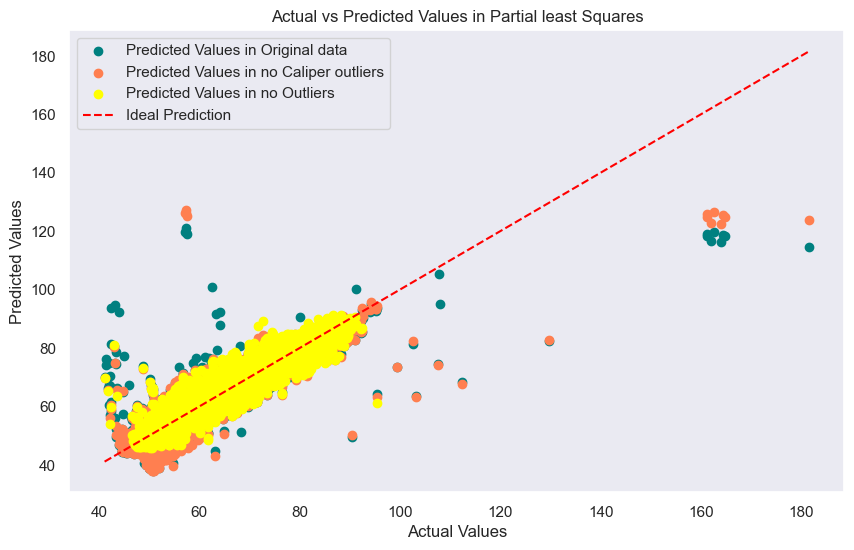

In [47]:
plt.figure(figsize=(10, 6))
plt.scatter(y_all, pls_pred_1, color='teal', label='Predicted Values in Original data')
plt.scatter(y_small, pls_pred_2, color='coral', label='Predicted Values in no Caliper outliers')
plt.scatter(y_no_out, pls_pred_3, color='yellow', label='Predicted Values in no Outliers')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Values in Partial least Squares')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Cubist(Ensemble) Model 

In [48]:
from cubist import Cubist
from sklearn.metrics import mean_absolute_error, r2_score

cb_model_1 = Cubist()
cb_model_2 = clone(cb_model_1)
cb_model_3 = clone(cb_model_1)

cb_model_1.fit(x_all,y_all)
cb_model_2.fit(x_small, y_small)
cb_model_3.fit(x_no_out, y_no_out)

cb_pred_1 = cb_model_1.predict(x_all)
cb_pred_2 = cb_model_2.predict(x_small)
cb_pred_3 = cb_model_3.predict(x_no_out)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [ ]:
cb_cv1 = cross_validate(cb_model_1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
cb_cv2 = cross_validate(cb_model_2, x_small, y_small, scoring= ['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)
cb_cv3 = cross_validate(cb_model_3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'],return_train_score=True, cv =5)

c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warnings.warn(
c:\Users\yoges\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Cubist was fitted with feature names
  warni

In [ ]:
result_cbst = model_evaluation(cb_cv1,cb_cv2,cb_cv3)
result_cbst

,Train MAE,Validation MAE,Train MSE,Test MSE,Train R2,Test R2
all data,-1.029930,-5.018328,-4.966377,-46.752721,0.958195,0.283031
no_caliper_outlier,-0.946008,-5.252854,-3.456062,-53.226974,0.969814,0.433225
no_outliers,-0.900506,-4.229753,-2.099279,-32.738741,0.974218,0.101018


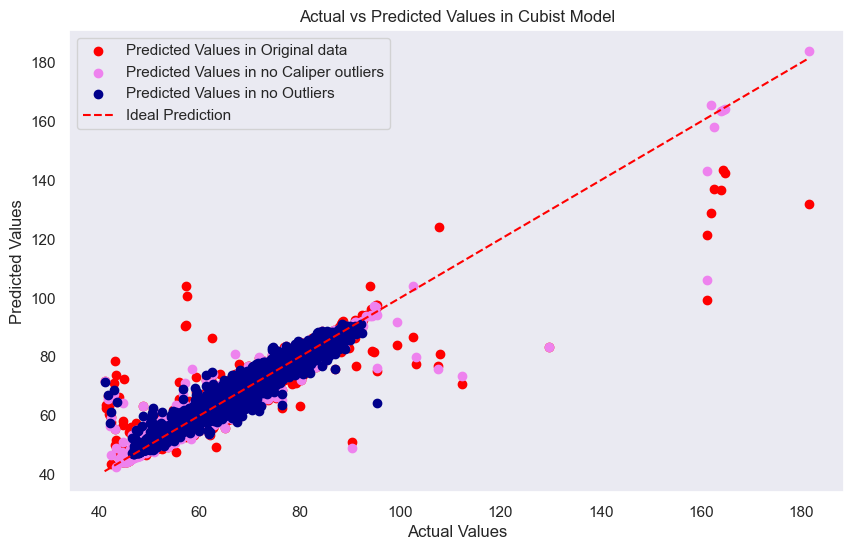

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_all, cb_pred_1, color='red', label='Predicted Values in Original data')
plt.scatter(y_small, cb_pred_2, color='violet', label='Predicted Values in no Caliper outliers')
plt.scatter(y_no_out, cb_pred_3, color='darkblue', label='Predicted Values in no Outliers')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Values in Cubist Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

# Extreme Gradient boosted Trees (XGBoost Regressor)

In [49]:
import xgboost as xgb

xgb_reg1 = xgb.XGBRegressor(objective='reg:squarederror', n_estimators =100, learning_rate = 0.1 )
xgb_reg2 = clone(xgb_reg1)
xgb_reg3 = clone(xgb_reg1)

xgb_reg1.fit(x_all, y_all)
xgb_reg2.fit(x_small, y_small)
xgb_reg3.fit(x_no_out, y_no_out)

xgb_pred_1 = xgb_reg1.predict(x_all)
xgb_pred_2 = xgb_reg2.predict(x_small)
xgb_pred_3 = xgb_reg3.predict(x_no_out)

In [50]:
xgb_cv1 = cross_validate(xgb_reg1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)
xgb_cv2 = cross_validate(xgb_reg2, x_small, y_small, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)
xgb_cv3 = cross_validate(xgb_reg3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)


In [51]:
result_xgb = model_evaluation(xgb_cv1,xgb_cv2,xgb_cv3)
result_xgb

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-1.024920,-3.248815,-2.193595,-25.760834,0.981048
no_caliper_outlier,-0.980934,-3.316319,-2.002474,-25.943133,0.982605
no_outliers,-0.896317,-3.056754,-1.587558,-18.120125,0.980425


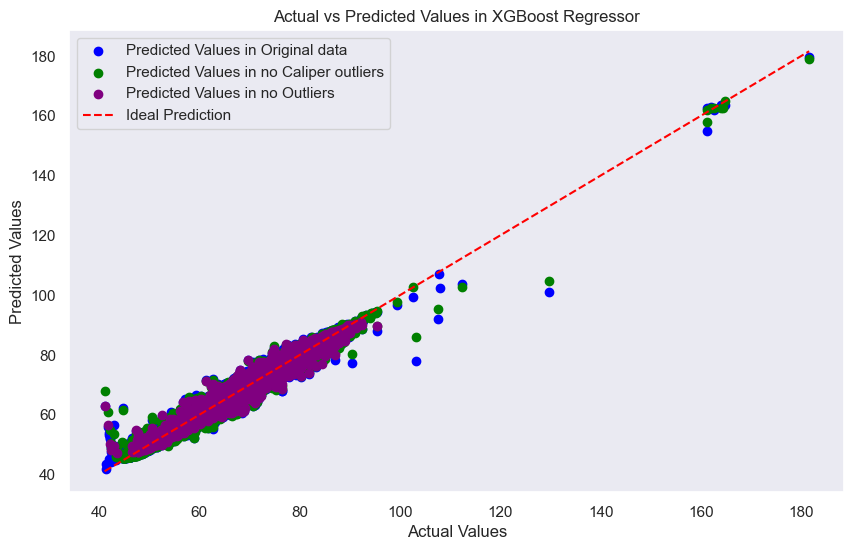

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(y_all, xgb_pred_1, color='blue', label='Predicted Values in Original data')
plt.scatter(y_small, xgb_pred_2, color='green', label='Predicted Values in no Caliper outliers')
plt.scatter(y_no_out, xgb_pred_3, color='purple', label='Predicted Values in no Outliers')
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Values in XGBoost Regressor')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

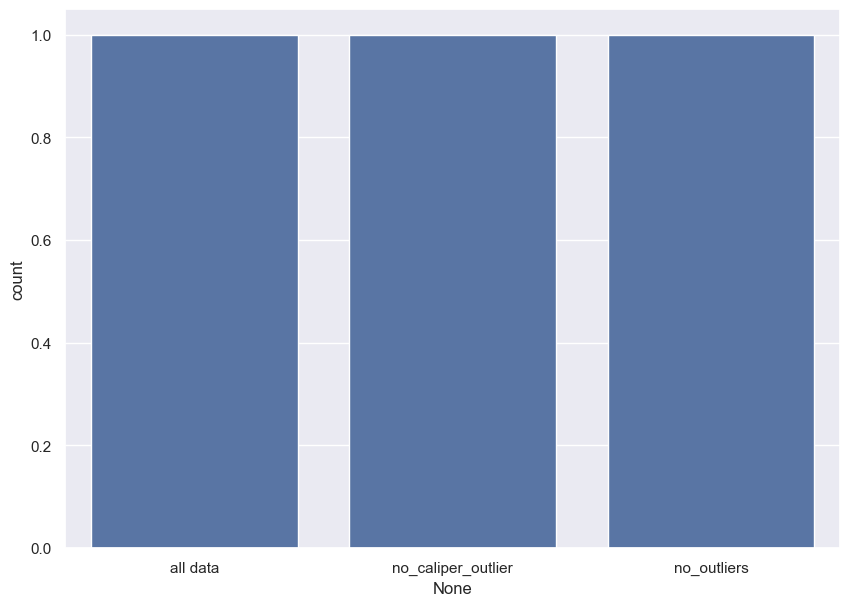

In [53]:
plt.figure(figsize=(10,7))
sns.countplot(x = result_xgb.index ,data=result_xgb)
plt.show()

In [54]:
result_xgb.columns

Index(['Train MAE', 'Validation MAE', 'Train MSE', 'Test MSE', 'R2'], dtype='object')

# ExtraTree Regressor

In [55]:
from sklearn.ensemble import ExtraTreesRegressor

etr_reg1 = ExtraTreesRegressor(n_estimators=100, max_depth=12,
                              bootstrap=True, random_state=42, verbose=2)
etr_reg2 = clone(etr_reg1)
etr_reg3 = clone(etr_reg1)

etr_reg1.fit(x_all, y_all)
etr_reg2.fit(x_small, y_small)
etr_reg3.fit(x_no_out, y_no_out)

etr_pred_1 = xgb_reg1.predict(x_all)
etr_pred_2 = xgb_reg2.predict(x_small)
etr_pred_3 = xgb_reg3.predict(x_no_out)

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


In [56]:
etr_cv1 = cross_validate(etr_reg1, x_all, y_all, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)
etr_cv2 = cross_validate(etr_reg2, x_small, y_small, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)
etr_cv3 = cross_validate(etr_reg3, x_no_out, y_no_out, scoring=['neg_mean_absolute_error','neg_mean_squared_error', 'r2'], return_train_score=True, cv=5)


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 1

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100
building tree 1 of 100
building tree 2 of 100
building tree 3 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 o

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90 of 100
building tree 91 of 100
building tree 92 of 100
building tree 93 of 100
building tree 94 of 100
building tree 95 of 100
building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


In [57]:
result_etr = model_evaluation(etr_cv1,etr_cv2,etr_cv3)
result_etr

,Train MAE,Validation MAE,Train MSE,Test MSE,R2
all data,-1.112737,-3.131884,-2.893125,-24.265870,0.974939
no_caliper_outlier,-1.074029,-3.012729,-2.621394,-22.037547,0.977154
no_outliers,-1.007700,-2.871394,-2.052149,-16.346545,0.974500


## Model Test Results

Of all the models the Random Forest produced the best result, the model is then used to predict the test data

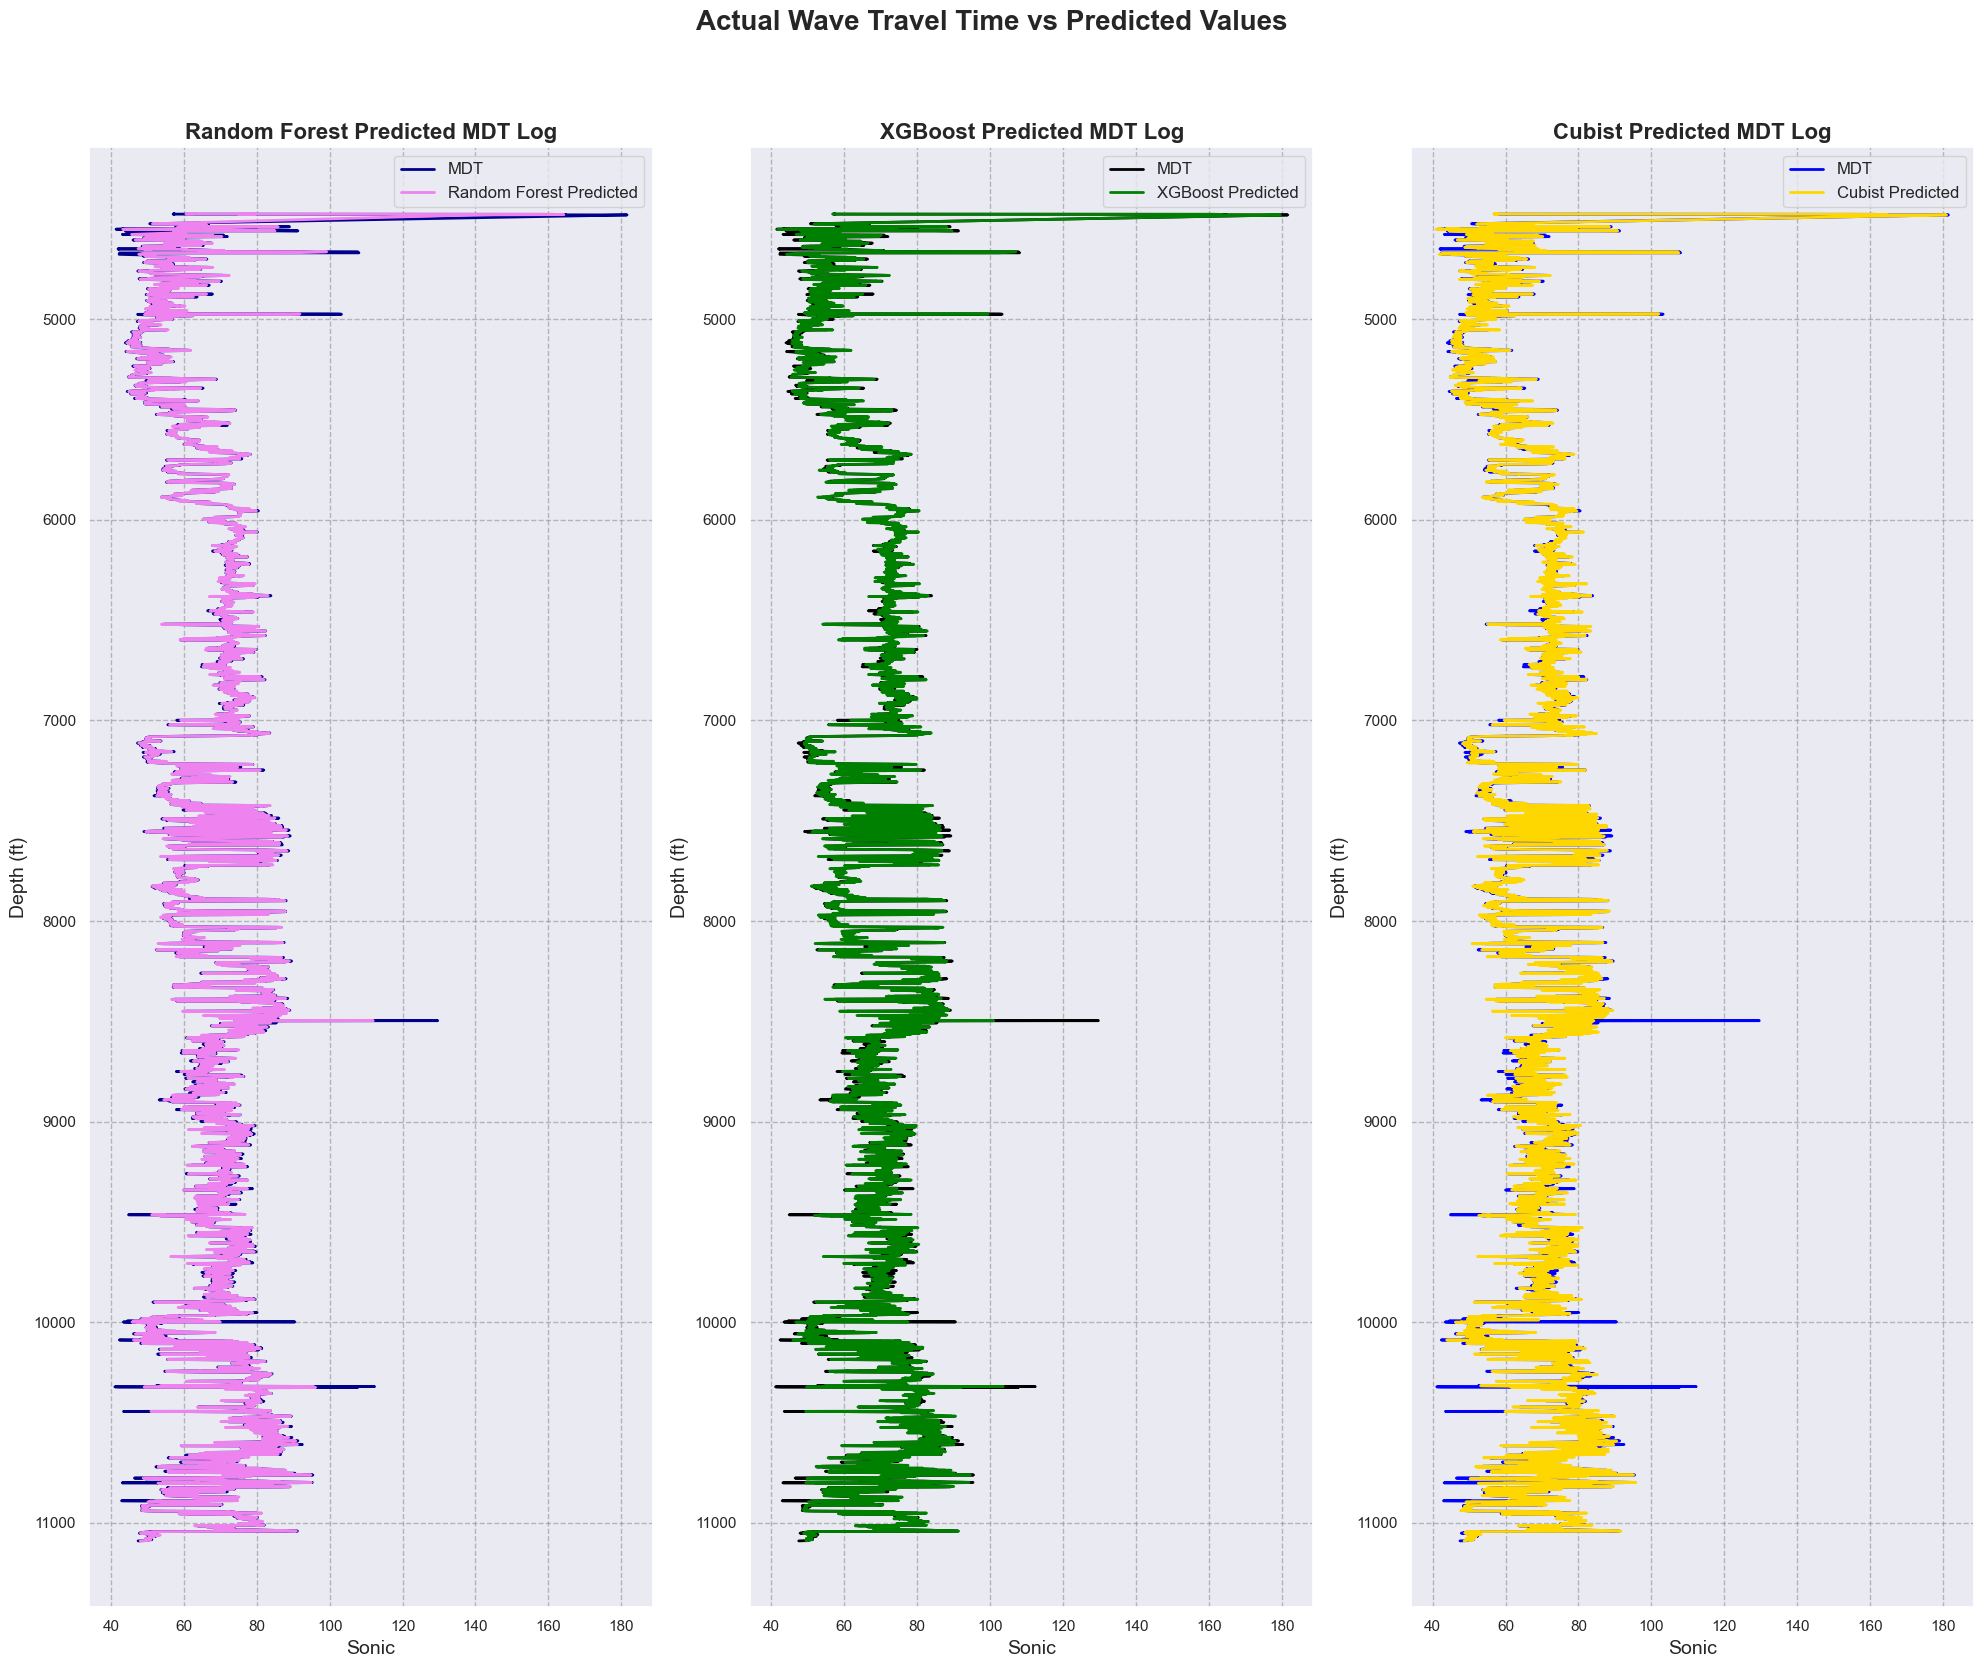

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 17))

# Random Forest
ax[0].plot(train['MDT'], train['DEPT'], color='darkblue', label='MDT', linewidth=2)
ax[0].plot(y_train_pred1, train['DEPT'], color='violet', label='Random Forest Predicted', linewidth=2)
ax[0].invert_yaxis()  # Invert the y-axis for depth
ax[0].set_xlabel('Sonic', fontsize=14)
ax[0].set_ylabel('Depth (ft)', fontsize=14)
ax[0].set_title('Random Forest Predicted MDT Log', fontsize=16, fontweight='bold')
ax[0].legend(fontsize=12)
ax[0].grid(color='gray', linestyle='--', alpha=0.5)

# XGBoost 
ax[1].plot(train['MDT'], train['DEPT'], color='black', label='MDT', linewidth=2)
ax[1].plot(xgb_pred_1, train['DEPT'], color='green', label='XGBoost Predicted', linewidth=2)
ax[1].invert_yaxis()  # Invert the y-axis for depth
ax[1].set_xlabel('Sonic', fontsize=14)
ax[1].set_ylabel('Depth (ft)', fontsize=14)
ax[1].set_title('XGBoost Predicted MDT Log', fontsize=16, fontweight='bold')
ax[1].legend(fontsize=12)
ax[1].grid(color='gray', linestyle='--', alpha=0.5)

# Cubist model
ax[2].plot(train['MDT'], train['DEPT'], color='blue', label='MDT', linewidth=2)
ax[2].plot(svr_pred_1, train['DEPT'], color='gold', label='Cubist Predicted', linewidth=2)
ax[2].invert_yaxis()  # Invert the y-axis for depth
ax[2].set_xlabel('Sonic', fontsize=14)
ax[2].set_ylabel('Depth (ft)', fontsize=14)
ax[2].set_title('Cubist Predicted MDT Log', fontsize=16, fontweight='bold')
ax[2].legend(fontsize=12)
ax[2].grid(color='gray', linestyle='--', alpha=0.5)

# Overall title for the figure
plt.suptitle('Actual Wave Travel Time vs Predicted Values', fontsize=20, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Show the plots
plt.show()

# Comparing the ensemble models vs stanalone models

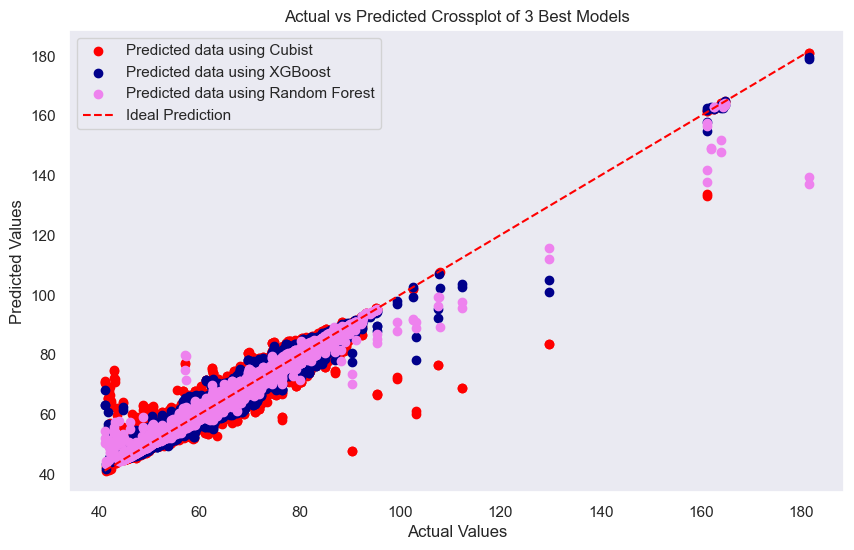

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_all, y_pred_all, color='darkblue', label='Predicted data using Standalone Models')
plt.scatter(y_small, y_pred_small, color='darkblue')
plt.scatter(y_no_out, y_pred_no_out, color='darkblue' )
plt.scatter(y_all, svr_pred_1, color='darkblue')
plt.scatter(y_small, svr_pred_2, color='darkblue')
plt.scatter(y_no_out, svr_pred_3, color='darkblue')


plt.scatter(y_all, svr_pred_1, color='red', label='Predicted data using Cubist')
plt.scatter(y_small, svr_pred_2, color='red')
plt.scatter(y_no_out, svr_pred_3, color='red' )
plt.scatter(y_all, xgb_pred_1, color='darkblue', label='Predicted data using XGBoost')
plt.scatter(y_small, xgb_pred_2, color='darkblue')
plt.scatter(y_no_out, xgb_pred_3, color='darkblue' )
plt.scatter(y_all, y_train_pred1, color='violet', label='Predicted data using Random Forest')
plt.scatter(y_small, y_train_pred2, color='violet')
plt.scatter(y_no_out, y_train_pred3, color='violet' )
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='red', linestyle='--', label='Ideal Prediction')
plt.title('Actual vs Predicted Crossplot of 3 Best Models')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid()
plt.show()

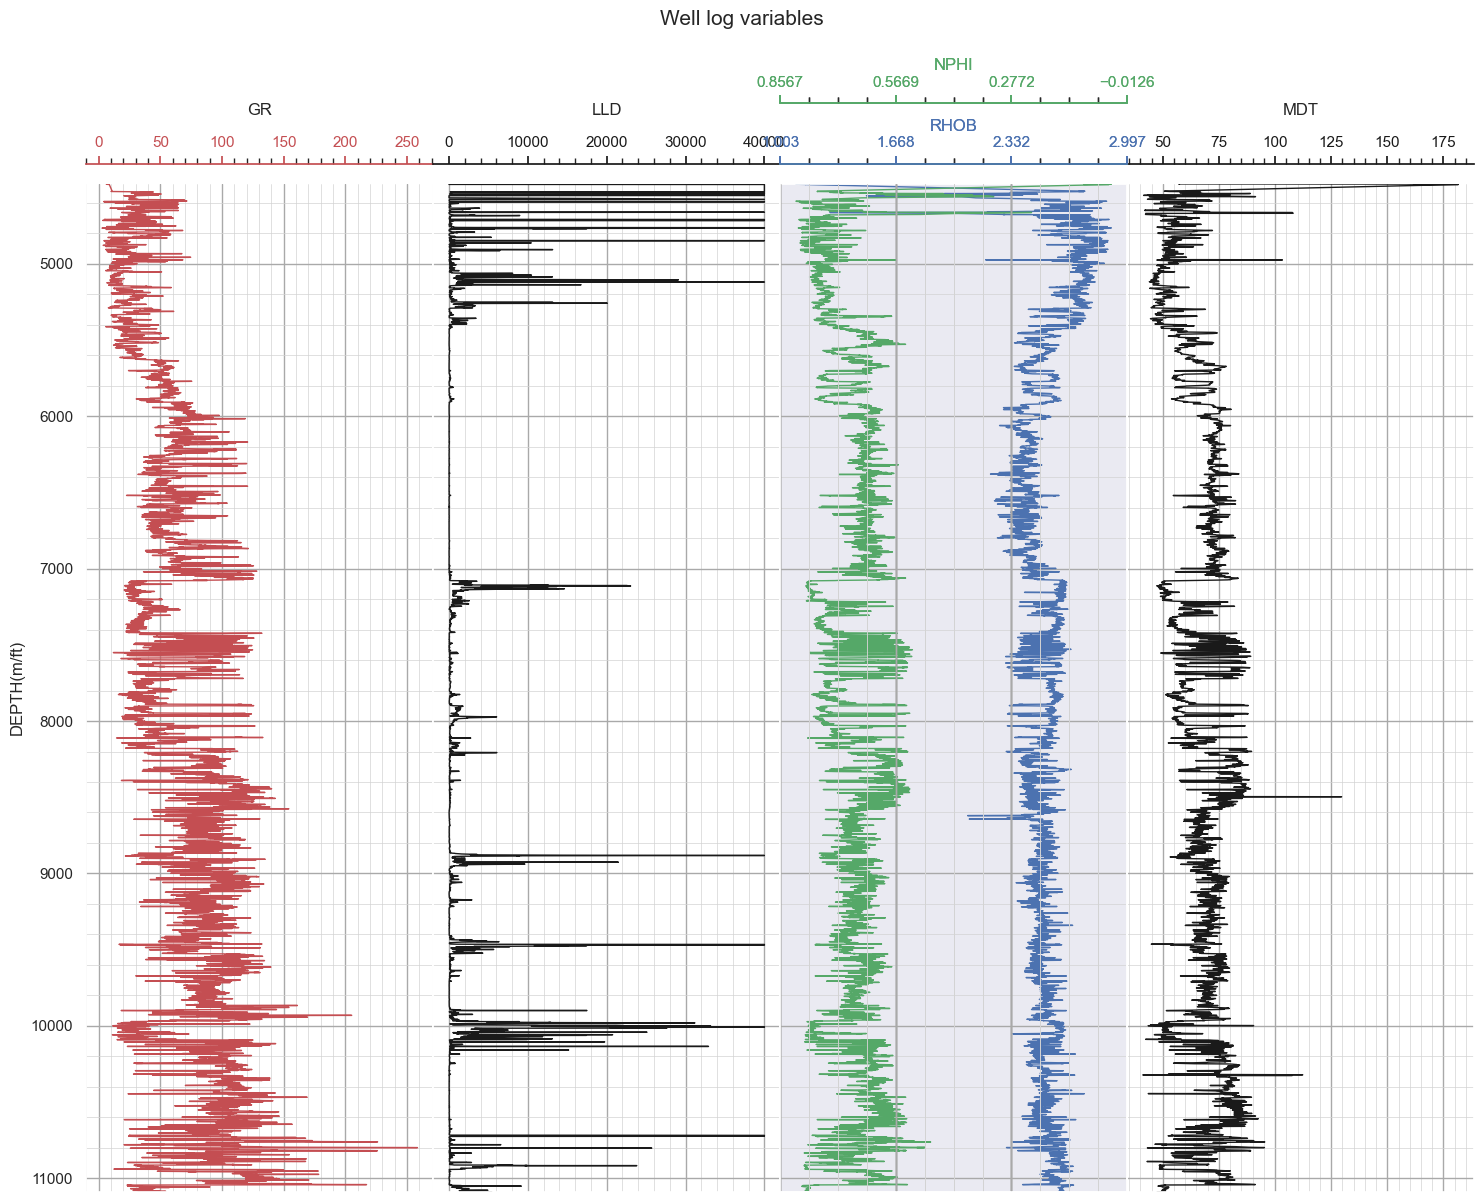

In [ ]:
plotLogs(train, depth='DEPT', logs=['GR', 'LLD', ['RHOB', 'NPHI'], 'MDT'], top=min(train['DEPT']), 
        bottom=max(train['DEPT']), figsize=(15,12), title='Well log variables')

In [ ]:
train['random_forest_prediction'] = y_train_pred1
train['xgboost_prediction'] = xgb_pred_1
train['cubist_prediction'] = svr_pred_1

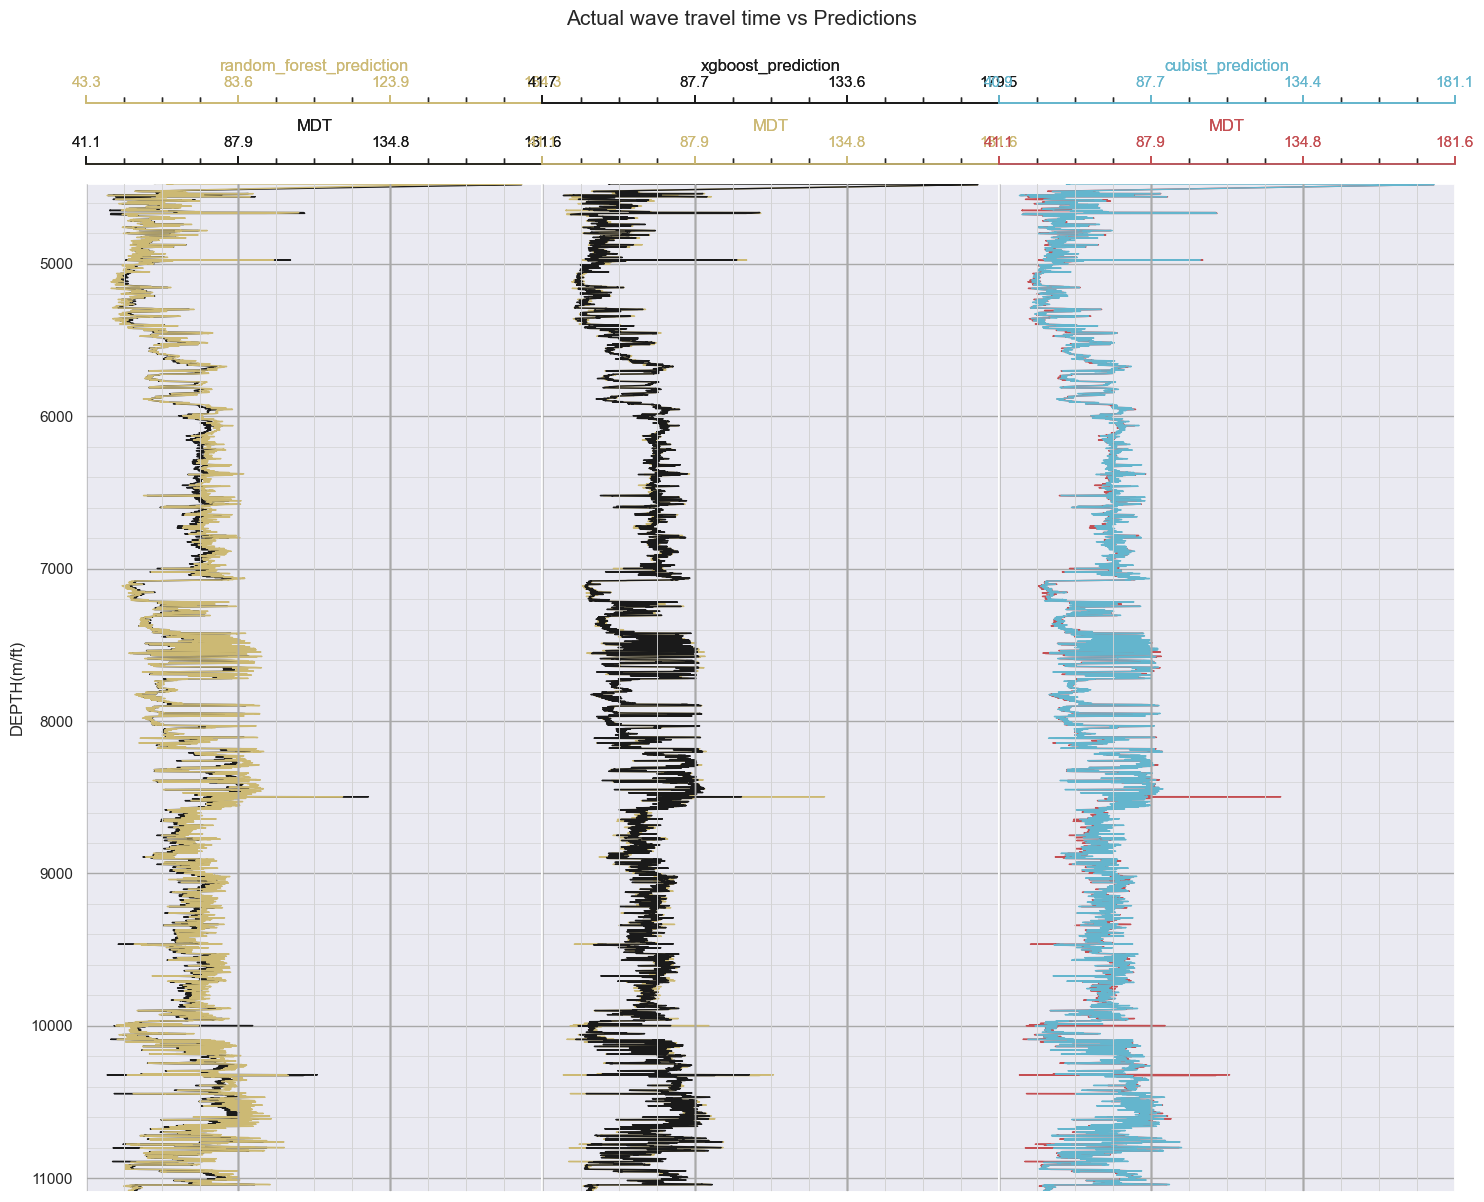

In [ ]:
plotLogs(train, depth='DEPT', logs=[['MDT', 'random_forest_prediction'], ['MDT', 'xgboost_prediction'], ['MDT', 'cubist_prediction']], top=min(train['DEPT']), 
        bottom=max(train['DEPT']), figsize=(15,12), title='Actual wave travel time vs Predictions')

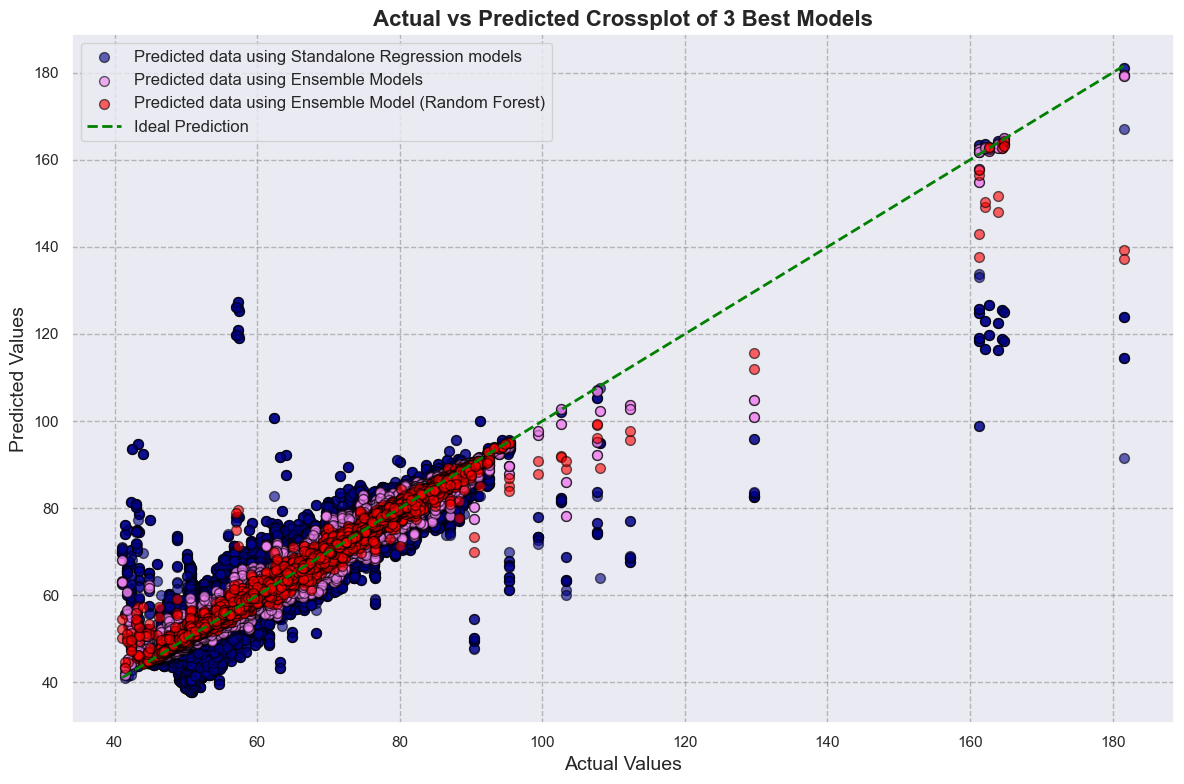

In [63]:
plt.figure(figsize=(12, 8))

#crossplot of the Standalone models
plt.scatter(y_all, lin_pred1, color='darkblue', alpha=0.6, label='Predicted data using Standalone Regression models', edgecolor='black', s=50)
plt.scatter(y_small, lin_pred2, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, lin_pred3, color='darkblue', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, elastic_pred_1, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_small, elastic_pred_2, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, elastic_pred_3, color='darkblue', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, pls_pred_1, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_small, pls_pred_2, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, pls_pred_3, color='darkblue', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, knn_y_pred1, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_small, knn_y_pred2, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, knn_y_pred3, color='darkblue', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, svr_pred_1, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_small, svr_pred_2, color='darkblue', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, svr_pred_3, color='darkblue', alpha=0.6, edgecolor='black', s=50)

# Crossplot of the Ensemble models
plt.scatter(y_all, etr_pred_1, color='violet', alpha=0.6, label='Predicted data using Ensemble Models', edgecolor='black', s=50)
plt.scatter(y_small, etr_pred_2, color='violet', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, etr_pred_3, color='violet', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, xgb_pred_1, color='violet', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_small, xgb_pred_2, color='violet', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, xgb_pred_3, color='violet', alpha=0.6, edgecolor='black', s=50)

plt.scatter(y_all, y_train_pred1, color='red', alpha=0.6, label = 'Predicted data using Ensemble Model (Random Forest)', edgecolor='black', s=50)
plt.scatter(y_small, y_train_pred2, color='red', alpha=0.6, edgecolor='black', s=50)
plt.scatter(y_no_out, y_train_pred3, color='red', alpha=0.6, edgecolor='black', s=50)

# Ideal prediction line
plt.plot([y_all.min(), y_all.max()], [y_all.min(), y_all.max()], color='green', linestyle='--', linewidth=2, label='Ideal Prediction')

# Title and labels
plt.title('Actual vs Predicted Crossplot of 3 Best Models', fontsize=16, fontweight='bold')
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(color='gray', linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()